# <center><span style="color:#FF7F50"><u> SDA - Projet 3 Text Mining : Suivi du #Ukraine</u><br><br>*Anne - Alicia - Julie - Valentina *</span></center>
***

## <span style="color:#191970"> Objectif :</span>
L’objectif de ce projet est de produire une analyse des tweets en français sur la guerre russo-ukrainienne de 2022.<br><br>
Pour cela : produire une analyse descriptive des tweets collectés et utiliser des modèles de Machine Learning pour essayer de faire émerger les grandes thématiques évoquées et suivre leur évolution.

## <span style="color:#191970">Import des packages</span>

In [24]:
import os
path = "C:/Users/vnarv/PycharmProjects/twitter_text_mining/"
os.chdir(path)

In [25]:
import re
import time
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from french_lefff_lemmatizer.french_lefff_lemmatizer import \
    FrenchLefffLemmatizer
from langdetect import DetectorFactory, detect
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
from wordcloud import WordCloud

from notebooks.utils import (get_tfidf_top_features, get_top_n_words,
                             ngram_top, wordcloud_cols)
from src.model.modelling import *
from src.preprocessing.preprocessing import preprocessing
from src.preprocessing.tools_preprocessing import read_files, transform_dates

## <span style="color:#191970">1. Import des données</span>

In [26]:
data = read_files(os.path.join(path, "data/min_retweet_3/"))

C:\Users\vnarv\PycharmProjects\twitter_text_mining


## <span style="color:#191970">2. Analyse exploratoire</span>

### <span style="color:#191970">2.1. Description des données</span>

### Périmètre: 

Les tweets extraits correspondent à ceux ayant au moins 3 retweets.
Nous avons fait l'hypothèse suivante: les tweets les plus relayés montrent des discours qui ont eu le plus d'impact dans ce réseau social.  
Tout au long des analyses, nous verrons que ce filtre favorise les tweets produits par des "influenceurs": des chaînes d'info, journalistes et influencers qui ont un certain nombre de "followers".

***Note sur l'extraction : Nous avons extrait 50 tweets dans une fenêtre de temps de 30  minutes tous les jours entre février et juin 2022.***

#### <span style="color:#191970">Types de variables</span>

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19939 entries, 0 to 19938
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   datetime       19939 non-null  object
 1   tweet_id       19939 non-null  int64 
 2   text           19939 non-null  object
 3   username       19939 non-null  object
 4   like_count     19939 non-null  int64 
 5   retweet_count  19939 non-null  int64 
 6   reply_count    19939 non-null  int64 
 7   quote_count    19939 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.2+ MB


In [28]:
data.dtypes

datetime         object
tweet_id         int64 
text             object
username         object
like_count       int64 
retweet_count    int64 
reply_count      int64 
quote_count      int64 
dtype: object

In [29]:
data.head()

datetime             tweet_id  \
0  2022-02-01 08:44:30+00:00  1488433061196812291   
1  2022-02-01 09:42:34+00:00  1488447673883676672   
2  2022-02-01 12:43:38+00:00  1488493240475078658   
3  2022-02-01 13:20:13+00:00  1488502446771081216   
4  2022-02-01 13:56:13+00:00  1488511509961527302   

                                                                                                                                                                                                                                                                                             text  \
0  Voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #EmmanuelMacron et #VladimirPoutine sur l'#Ukraine. https://t.co/yyXEtpNxUC                                                                                                       
1  #Ukraine Face à Poutine ... Macron hausse le ton ! https://t.co/mFpSevIDLV                                                                                                                                                                                                                       
2  Crise en #Ukraine : « Emmanuel #Macron et Vladimir #Poutine, se sont reparlés hier soir. Il y a un dialogue et des échanges nourris. On veut éviter un conflit armé à nos portes. C'est encore possible » @GabrielAttal https://t.co/V7OvwB9n4I                                                  
3  La #Russie c'est l'équivalent du PIB de l'Italie. Attention aux sanctions qu'elle pourrait recevoir et monsieur Poutine est réaliste. On a loupé la relation avec la Russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvL   
4  Crise en #Ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’OTAN sur le champ ! Nouvelle vidéo ➡️ https://t.co/QjYACvG9pk                                                                                                                              

          username  like_count  retweet_count  reply_count  quote_count  
0  tcabarrus        58          33             2            0            
1  lapin47          230         103            36           24           
2  FaireEnsembleEM  63          17             6            0            
3  BrunoRetailleau  59          29             9            1            
4  f_philippot      745         236            34           5

In [30]:
data.tail()

datetime             tweet_id  \
19934  2022-07-01 20:23:10+00:00  1542967067611127813   
19935  2022-07-01 20:10:32+00:00  1542963887175335937   
19936  2022-07-01 20:39:44+00:00  1542971236459888641   
19937  2022-07-01 20:31:01+00:00  1542969041161158656   
19938  2022-07-01 21:21:38+00:00  1542981780092985344   

                                                                                                                                                                                                                                                                                                                          text  \
19934  C'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #Ukraine #Europe https://t.co/0yWT0ZWqot                                                                                                                                                                                                                                     
19935  👉 Guerre un #Ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"Il y a urgence : l'hiver qui arrive. Il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] Il faut investir massivement dans les régions libérées."\r\n\r\n📺 #Le20hdeDariusRochebin https://t.co/RH8jKShhcS   
19936  👉 Guerre en #Ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"On peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] On le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 #Le20hdeDariusRochebin @DariusRochebin https://t.co/ZlAQoQR2p5           
19937  Implacable. A gauche le peuple d’#Ukraine qui a compris que le drapeau de l’#Europe est celui de la paix. A droite @JLMelenchon et sa horde #LFI qui tournent le dos à l’Histoire. \r\n\r\nhttps://t.co/fp7wekkZrW                                                                                                        
19938  Les urgences d'un hôpital ferment faute de soignants. \r\n\r\nAlors qu'on a des milliers de soignants toujours pas réintégrés... \r\n\r\nPendant ce temps #Macron organise sa propagande dans des docs pourris sur @Francetele et donne 2 milliards à l'#Ukraine.\r\n\r\nhttps://t.co/qfxBlmwQQq                          

             username  like_count  retweet_count  reply_count  quote_count  
19934  Anna78__        57          20             2            2            
19935  LCI             136         59             171          28           
19936  LCI             54          28             38           4            
19937  PJakubowicz     948         438            265          25           
19938  LeDucDeLaToile  19          13             0            1

#### <span style="color:#191970">Recherche de doublons</span>

In [31]:
#nb de doublons
print(f"La base contient {data.duplicated().sum()} doublons.")

La base contient 0 doublons.


#### <span style="color:#191970">Refiltre sur tweets restants en anglais</span>

In [32]:
# lower case tweets
data["text"] = data["text"].str.lower()

# store all hashtags into a column
data["hashtags"] = data["text"].apply(lambda y: [x.group() for x in re.finditer(r'#[a-zA-Z]+', y)])

# Find all @
data["arrobas"] = data["text"].apply(lambda y: [x.group() for x in re.finditer(r'@[a-zA-Z]+', y)])

# replace https links with "link"
regex_http = r'([\w+]+\:\/\/)?([\w\d-]+\.)*[\w-]+[\.\:]\w+([\/\?\=\&\#\.]?[\w-]+)*\/?'

#data["text_clean"] = [re.sub(regex_http, '<link>', doc) for doc in data["text"]]
data["text_clean"] = [re.sub(regex_http, '', doc) for doc in data["text"]]
#en enlevant les accents et emoji : plus de tweets déclarés en anglais à tord => on garde les accents

In [33]:
data.head()

datetime             tweet_id  \
0  2022-02-01 08:44:30+00:00  1488433061196812291   
1  2022-02-01 09:42:34+00:00  1488447673883676672   
2  2022-02-01 12:43:38+00:00  1488493240475078658   
3  2022-02-01 13:20:13+00:00  1488502446771081216   
4  2022-02-01 13:56:13+00:00  1488511509961527302   

                                                                                                                                                                                                                                                                                             text  \
0  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc                                                                                                       
1  #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv                                                                                                                                                                                                                       
2  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i                                                  
3  la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
4  crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk                                                                                                                              

          username  like_count  retweet_count  reply_count  quote_count  \
0  tcabarrus        58          33             2            0             
1  lapin47          230         103            36           24            
2  FaireEnsembleEM  63          17             6            0             
3  BrunoRetailleau  59          29             9            1             
4  f_philippot      745         236            34           5             

                                                 hashtags          arrobas  \
0  [#medias, #emmanuelmacron, #vladimirpoutine, #ukraine]  []                
1  [#ukraine]                                              []                
2  [#ukraine, #macron, #poutine]                           [@gabrielattal]   
3  [#russie, #kiev, #ukraine]                              []                
4  [#ukraine]                                              []                

                                                                                                                                                                                                                                                                text_clean  
0  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine.                                                                                                       
1  #ukraine face à poutine ... macron hausse le ton !                                                                                                                                                                                                                       
2  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielat

In [34]:
# refiltre sur tweets restants en anglais
tweet_lg = []
for row in data.text_clean :
    tw_lang = detect(row)
    tweet_lg.append(tw_lang)
    
# création d'une colonne contenant la langue
data["language"] = tweet_lg

other_lang = data[data["language"] != "fr"]
nb_other_lang = other_lang.groupby("language")["tweet_id"].nunique()
print(f"Nb of tweets detected in other language {nb_other_lang}")
print(other_lang[["text_clean", "language"]].iloc[:10])
        
# Filtrer les tweets en français
is_french = "fr"
data = data[data["language"] == is_french]

# suppression des accents et emojis
data["text_clean"] = data["text_clean"].apply(lambda x: unidecode(x))
# replace all non alphabetic chars with an space
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r"[^a-z]+", " ", x))
# suppression des tweets vides
data = data[(data["text_clean"] != " ")]
# suppression des NAN
data = data[~data["text_clean"].isna()]

Nb of tweets detected in other language language
af    4 
ca    2 
cs    1 
da    1 
de    7 
en    38
et    6 
fi    10
hr    3 
id    3 
it    12
lt    2 
lv    2 
nl    4 
no    6 
pl    1 
sl    4 
sv    2 
Name: tweet_id, dtype: int64
                                                                                                                                                                                                                                                                                          text_clean  \
192   spanish minister of foreign affairs josé manuel albares en route to #ukraine  via @gdarkconrad                                                                                                                                                                                                   
386   #g7 finance ministers´ statement on #ukraine ➡️  @g7 #g7ger                                                                                                       

In [35]:
data.head()

datetime             tweet_id  \
0  2022-02-01 08:44:30+00:00  1488433061196812291   
1  2022-02-01 09:42:34+00:00  1488447673883676672   
2  2022-02-01 12:43:38+00:00  1488493240475078658   
3  2022-02-01 13:20:13+00:00  1488502446771081216   
4  2022-02-01 13:56:13+00:00  1488511509961527302   

                                                                                                                                                                                                                                                                                             text  \
0  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc                                                                                                       
1  #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv                                                                                                                                                                                                                       
2  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i                                                  
3  la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
4  crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk                                                                                                                              

          username  like_count  retweet_count  reply_count  quote_count  \
0  tcabarrus        58          33             2            0             
1  lapin47          230         103            36           24            
2  FaireEnsembleEM  63          17             6            0             
3  BrunoRetailleau  59          29             9            1             
4  f_philippot      745         236            34           5             

                                                 hashtags          arrobas  \
0  [#medias, #emmanuelmacron, #vladimirpoutine, #ukraine]  []                
1  [#ukraine]                                              []                
2  [#ukraine, #macron, #poutine]                           [@gabrielattal]   
3  [#russie, #kiev, #ukraine]                              []                
4  [#ukraine]                                              []                

                                                                                                                                                                                                                                                        text_clean  \
0  voila l info malheureusement tres peu reprise par les medias e entretien telephonique en jours entre emmanuelmacron et vladimirpoutine sur l ukraine                                                                                                              
1   ukraine face a poutine macron hausse le ton                                                                                                                                                                                                                      
2  crise en ukraine emmanuel macron et vladimir poutine se sont reparles hier soir il y a un dialogue et des echanges nourris on veut eviter un conflit arme a nos portes c est encore possible gabrielattal                                

### <span style="color:#191970">2.2. Statistiques globales</span>

#### <span style="color:#191970">Evolution nb de tweets</span>

In [36]:
data = transform_dates(df=data, column="datetime")

In [37]:
data['date'].min()

datetime.date(2022, 2, 1)

In [38]:
data['date'].max()

datetime.date(2022, 7, 1)

In [51]:
#evolution nb de tweet par jour 
#tpd=nb tweets per day
tpd = data.groupby("date")["tweet_id"].count().reset_index()
display(tpd)

date  tweet_id
0    2022-02-01  12      
1    2022-02-02  12      
2    2022-02-03  13      
3    2022-02-04  21      
4    2022-02-05  7       
..          ... ..       
146  2022-06-27  70      
147  2022-06-28  58      
148  2022-06-29  42      
149  2022-06-30  42      
150  2022-07-01  51      

[151 rows x 2 columns]

In [52]:
#line plot evolution du nb de tweets par jour
fig = px.line(tpd,
              x='date',
              y='tweet_id',
              title='Evolution du nb de tweets par jour', 
              labels={
                     "tweet_id": "Nb de tweets"
                 })
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Pic du nombre de tweets sur 5 jours à partir du début de la guerre le 24 février 2021, jusqu'au 1er mars 2021, puis une phase de décroissance significative du nombre de tweets par jour durant un mois, pour se stabiliser sur une moyenne d'une cinquantaine de tweets par jour.

22/02 : Russie reconnaît l'indépendance des territoires séparatistes dans le Donbass (indépendance de la république populaire de Donetsk et de la république populaire de Lougansk)<br>
24/02 : la guerre éclate<br>
27/02 : Russie menace nucléaire / UE envoie des armes à l'Ukraine <br>
09/03 : une maternité bombardée à Marioupol <br>
13/03 : Russie bombarde une base Ukrainienne vers la Pologne <br>
16/03 : Russie exclue du Conseil de l'Europe / Un théâtre abritant "des centaines de civils" visé par une frappe aérienne russe dans le port assiégé de Marioupol / Joe Biden, a qualifié Poutine de "criminel de guerre"<br>
24/03 : changement de stratégie du Kremlin<br>
pics 03-04-05/04 : Fin mars, l’échec de l’offensive russe sur Kiev / démonstration de force de la Russie / les crimes russes découverts à Boutcha<br>
14/04 : le « Moskva » coule<br>
23/04 : retrait des troupes russes<br>
30/05 : embargo officiel sur le pétrole russe<br>
16/06 : Visite des présidents français, allemand et italien<br>

#### <span style="color:#191970">Stats descriptives - variables numériques</span>

In [53]:
count_var = ['like_count','retweet_count','reply_count','quote_count']
data[count_var].describe()

like_count  retweet_count   reply_count   quote_count
count  19831.000000  19831.000000   19831.000000  19831.000000
mean   367.818516    91.886390      25.016792     11.803237   
std    1825.556910   299.271669     84.843577     84.867607   
min    1.000000      3.000000       0.000000      0.000000    
25%    39.000000     20.000000      2.000000      1.000000    
50%    72.000000     31.000000      6.000000      2.000000    
75%    172.000000    62.000000      17.000000     5.000000    
max    76494.000000  15137.000000   3512.000000   6546.000000

En moyenne un tweet est liké 373 fois et peut aller jusqu'à un maximum de 76494 like. <br>
Par ailleurs, un tweet est retweeté 93 fois en moyenne et peut être retweeté au maximum 15137 fois.<br>
Les tweets les plus populaires sont les tweets de "libe", les plus likés et les plus retweetés sont de Mediapart.

In [54]:
data['username'].value_counts()

libe               550
tcabarrus          493
LCI                493
CerfiaFR           428
CedricMas          360
                  ... 
Conseil_EPF        1  
bluetouff          1  
GeopolitiqueRFI    1  
AcadSciences       1  
bitznarweb         1  
Name: username, Length: 4304, dtype: int64

In [55]:
# classement des username qui sont le plus retweetés
# tpu = tweets per user
tpu = data.groupby("username")["tweet_id"].count().reset_index()
tpu = tpu.sort_values(by='tweet_id', ascending=False)

In [56]:
tpu.reset_index(drop=True, inplace=True)

In [57]:
tpu_20 = tpu.iloc[0:20]

In [58]:
#20 premiers usernames qui ont été le plus retweetés 
tpu_20

username  tweet_id
0   libe             550     
1   tcabarrus        493     
2   LCI              493     
3   CerfiaFR         428     
4   CedricMas        360     
5   France24_fr      296     
6   le_Parisien      285     
7   Le_Figaro        232     
8   CorentinSellin   205     
9   francediplo      187     
10  Mediavenir       170     
11  lemondefr        159     
12  afpfr            158     
13  andreivaitovich  158     
14  bechetgolovko    139     
15  stefsiohan       137     
16  UkraineStand     135     
17  YvesPDB          135     
18  ulyssepariser    128     
19  LPLdirect        128

In [59]:
#20 premiers "tweeters" sur la période
fig3 = px.bar(tpu_20,
              x='tweet_id',
              y='username',
              orientation='h',
              title='Top 20 des tweets dans le périmètre',
              labels={
                     "tweet_id": "Nb de tweets"
                 }
             )
fig3.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Dans les premiers username qui sont le plus retweetés, on retrouve beaucoup de grands journaux/médias tels que Libé, LCI, France24, Le Parisien mais aussi des personalités comme des journalistes tels que Thierry de Cabarrus (tcabarrus) ou encore des historiens comme Cedric Mas ou Corentin Sellin.

#### <span style="color:#191970">Distributions - variables numériques</span>

In [60]:
#Boxplots - Distribution des données
fig = go.Figure()

fig.add_trace(go.Box(x=data["like_count"], name="like_count"))
fig.add_trace(go.Box(x=data["retweet_count"], name="retweet_count"))
fig.update_layout(
    title="Distribution des retweets et des likes dans le périmètre"
)
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [61]:
data[data['like_count']>50000].sort_values(by='retweet_count', ascending=False).head()

datetime             tweet_id  \
16037 2022-04-14 08:46:00+00:00  1514525365158436866   
15907 2022-04-12 11:54:30+00:00  1513848028289019906   
11934 2022-03-14 15:33:55+00:00  1503393999452786690   
3124  2022-02-25 10:16:20+00:00  1497153481525936128   

                                                                                                                                                                                                                                                                                        text  \
16037  🇺🇳 flash - le directeur général de l'#oms estime que le monde "ne prête pas le même degré d'attention aux vies des noirs et à celles des blancs", et regrette que les guerres au yémen, en afghanistan ou en syrie ne suscitent pas la même attention que celle en #ukraine. (afp)      
15907  🇺🇦 le mot "macroner" est né en #ukraine. définition : "se montrer très inquiet d’une situation, mais ne rien faire, en fait", un néologisme inspiré d'emmanuel #macron "dont on ne se souvient pas pour une aide réelle, mais pour ses photos préoccupées de l’élysée". (le parisien)   
11934  🇺🇸🇷🇺 insolite : elon musk défie vladimir #poutine dans un "combat d'homme à homme" avec comme enjeu l'#ukraine. il affirme être "tout à fait sérieux". (afp)                                                                                                                            
3124   💻🇷🇺 flash - le collectif de hackers #anonymous a déclaré la “cyberguerre” à la #russie suite à l’invasion de l’#ukraine. (bfmtv) #laguerre #ukrainerussie                                                                                                                               

         username  like_count  retweet_count  reply_count  quote_count  \
16037  Mediavenir  58690       15137          845          1378          
15907  Mediavenir  51724       9649           560          1306          
11934  Mediavenir  76494       8731           1196         3022          
3124   Mediavenir  69192       7424           685          1178          

                                                         hashtags arrobas  \
16037  [#oms, #ukraine]                                            []       
15907  [#ukraine, #macron]                                         []       
11934  [#poutine, #ukraine]                                        []       
3124   [#anonymous, #russie, #ukraine, #laguerre, #ukrainerussie]  []       

                                                                                                                                                                                                                                                                   text_clean  \
16037   flash le directeur general de l oms estime que le monde ne prete pas le meme degre d attention aux vies des noirs et a celles des blancs et regrette que les guerres au yemen en afghanistan ou en syrie ne suscitent pas la meme attention que celle en ukraine afp    
15907   le mot macroner est ne en ukraine definition se montrer tres inquiet d une situation mais ne rien faire en fait un neologisme inspire d emmanuel macron dont on ne se souvient pas pour une aide reelle mais pour ses photos preoccupees de l elysee le parisien        
11934   insolite elon musk defie vladimir poutine dans un combat d homme a homme avec comme enjeu l ukraine il affirme etre tout a fait serieux afp                                                                                                                             
3124    flash le collectif de hackers anonymous a declare la cyberguerre a la russie suite a l invasion de l ukraine bfmtv laguerre ukrainerussie                                                                                                                               

      language        date  day  month      time  hour  minute  
16037  fr       2022-04-14  14   4      08:46:00  8     46      
15907  fr       2022-04-12  12   4      11:54:30

In [62]:
data[data['like_count']>50000].sort_values(by='like_count', ascending=False).head()

datetime             tweet_id  \
11934 2022-03-14 15:33:55+00:00  1503393999452786690   
3124  2022-02-25 10:16:20+00:00  1497153481525936128   
16037 2022-04-14 08:46:00+00:00  1514525365158436866   
15907 2022-04-12 11:54:30+00:00  1513848028289019906   

                                                                                                                                                                                                                                                                                        text  \
11934  🇺🇸🇷🇺 insolite : elon musk défie vladimir #poutine dans un "combat d'homme à homme" avec comme enjeu l'#ukraine. il affirme être "tout à fait sérieux". (afp)                                                                                                                            
3124   💻🇷🇺 flash - le collectif de hackers #anonymous a déclaré la “cyberguerre” à la #russie suite à l’invasion de l’#ukraine. (bfmtv) #laguerre #ukrainerussie                                                                                                                               
16037  🇺🇳 flash - le directeur général de l'#oms estime que le monde "ne prête pas le même degré d'attention aux vies des noirs et à celles des blancs", et regrette que les guerres au yémen, en afghanistan ou en syrie ne suscitent pas la même attention que celle en #ukraine. (afp)      
15907  🇺🇦 le mot "macroner" est né en #ukraine. définition : "se montrer très inquiet d’une situation, mais ne rien faire, en fait", un néologisme inspiré d'emmanuel #macron "dont on ne se souvient pas pour une aide réelle, mais pour ses photos préoccupées de l’élysée". (le parisien)   

         username  like_count  retweet_count  reply_count  quote_count  \
11934  Mediavenir  76494       8731           1196         3022          
3124   Mediavenir  69192       7424           685          1178          
16037  Mediavenir  58690       15137          845          1378          
15907  Mediavenir  51724       9649           560          1306          

                                                         hashtags arrobas  \
11934  [#poutine, #ukraine]                                        []       
3124   [#anonymous, #russie, #ukraine, #laguerre, #ukrainerussie]  []       
16037  [#oms, #ukraine]                                            []       
15907  [#ukraine, #macron]                                         []       

                                                                                                                                                                                                                                                                   text_clean  \
11934   insolite elon musk defie vladimir poutine dans un combat d homme a homme avec comme enjeu l ukraine il affirme etre tout a fait serieux afp                                                                                                                             
3124    flash le collectif de hackers anonymous a declare la cyberguerre a la russie suite a l invasion de l ukraine bfmtv laguerre ukrainerussie                                                                                                                               
16037   flash le directeur general de l oms estime que le monde ne prete pas le meme degre d attention aux vies des noirs et a celles des blancs et regrette que les guerres au yemen en afghanistan ou en syrie ne suscitent pas la meme attention que celle en ukraine afp    
15907   le mot macroner est ne en ukraine definition se montrer tres inquiet d une situation mais ne rien faire en fait un neologisme inspire d emmanuel macron dont on ne se souvient pas pour une aide reelle mais pour ses photos preoccupees de l elysee le parisien        

      language        date  day  month      time  hour  minute  
11934  fr       2022-03-14  14   3      15:33:55  15    33      
3124   fr       2022-02-25  25   2      10:16:20

Les tweets les plus likés, retweetés, quotés et commentés sont les tweets de Mediavenir

#### <span style="color:#191970">Répartition des tweets/tranches de like</span>

In [63]:
tranches_like = [
    (data['like_count'] > 1000) ,
    (data['like_count'] > 200) & (data['like_count'] <= 1000),
    (data['like_count'] > 100) & (data['like_count'] <= 200),
    (data['like_count'] > 50) & (data['like_count'] <= 100),
    (data['like_count'] > 10) & (data['like_count'] <= 50),
    (data['like_count'] > 0) & (data['like_count'] <= 10),
    (data['like_count'] == 0)
]
choicelist = [">1000 likes", "[201-1000 likes]", "[101-200 likes]", "[51-100 likes]", "[11-50 likes]", "[1-10 likes]", "0 like"]
data['tranches_like'] = np.select(tranches_like, choicelist, default='Not Specified')

In [64]:
data.head()

datetime             tweet_id  \
0 2022-02-01 08:44:30+00:00  1488433061196812291   
1 2022-02-01 09:42:34+00:00  1488447673883676672   
2 2022-02-01 12:43:38+00:00  1488493240475078658   
3 2022-02-01 13:20:13+00:00  1488502446771081216   
4 2022-02-01 13:56:13+00:00  1488511509961527302   

                                                                                                                                                                                                                                                                                             text  \
0  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc                                                                                                       
1  #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv                                                                                                                                                                                                                       
2  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i                                                  
3  la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
4  crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk                                                                                                                              

          username  like_count  retweet_count  reply_count  quote_count  \
0  tcabarrus        58          33             2            0             
1  lapin47          230         103            36           24            
2  FaireEnsembleEM  63          17             6            0             
3  BrunoRetailleau  59          29             9            1             
4  f_philippot      745         236            34           5             

                                                 hashtags          arrobas  \
0  [#medias, #emmanuelmacron, #vladimirpoutine, #ukraine]  []                
1  [#ukraine]                                              []                
2  [#ukraine, #macron, #poutine]                           [@gabrielattal]   
3  [#russie, #kiev, #ukraine]                              []                
4  [#ukraine]                                              []                

                                                                                                                                                                                                                                                        text_clean  \
0  voila l info malheureusement tres peu reprise par les medias e entretien telephonique en jours entre emmanuelmacron et vladimirpoutine sur l ukraine                                                                                                              
1   ukraine face a poutine macron hausse le ton                                                                                                                                                                                                                      
2  crise en ukraine emmanuel macron et vladimir poutine se sont reparles hier soir il y a un dialogue et des echanges nourris on veut eviter un conflit arme a nos portes c est encore possible gabrielattal                                     

In [33]:
data.to_csv('./output/df_fr.csv', index=False)

In [35]:
data['tranches_like'].value_counts(normalize=True)

[11-50 likes]       0.347635
[51-100 likes]      0.256781
[201-1000 likes]    0.166784
[101-200 likes]     0.163709
>1000 likes         0.055158
[1-10 likes]        0.009932
Name: tranches_like, dtype: float64

In [36]:
#Histogramme de répartition des tweets par tranche de like
data = data.sort_values("like_count", ascending=True)
fig = px.histogram(data, x="tranches_like",
                   title="Histogramme de répartition des tweets par tranche de like",
                   labels={
                     "count": "Nb de tweets"
                 })
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



La plupart des tweets sont likés entre 11 et 100 fois (un tiers des tweets de la base) et 25% entre 50 et 100 fois.<br>
Très peu de tweets sont likés plus de 1000 fois : 6%.

#### <span style="color:#191970">Nuages de mots</span>

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vnarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


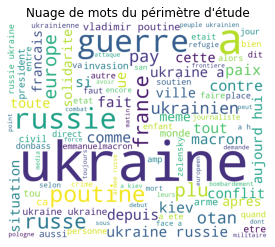

In [37]:
#Nuage de mots - tous les tweets
nltk.download('stopwords')
stopwords_set = set(stopwords.words('french')) 
wordcloud = WordCloud(background_color='white',
                           collocations=True, # Inclu les bigrammes
                           width=1200,
                           height=1000,
                           max_words=100,
                           stopwords=stopwords_set).generate(" ".join(data['text_clean']))

plt.title("Nuage de mots du périmètre d'étude")
plt.axis("off")
plt.imshow(wordcloud)
plt.savefig("wordcloud_general.png")

On peut voir des mots évoquant le soutien des autres Nations à l'Ukraine avec notamment : "paix", "soutien", "Europe", "France", "monde", "Otan", "sanction". <br>
On peut également voir des noms de villes qui ont fait l'actualité, ressortir et notamment "Khiev", "Donbass", "Kyiv" ou "Marioupol". <br>
On peut aussi voir des mots comme "crime", "mort", "militaire" ou "bombardement" qui témoignent de la situation de guerre.

# Nuage de mots par mois 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vnarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


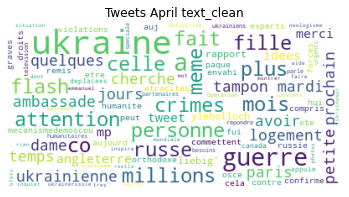

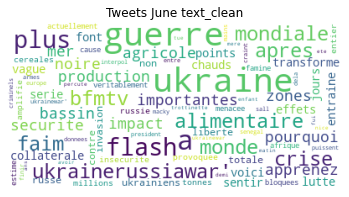

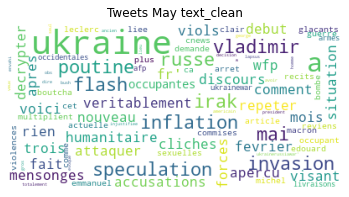

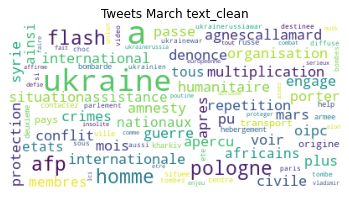

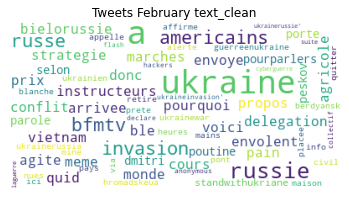

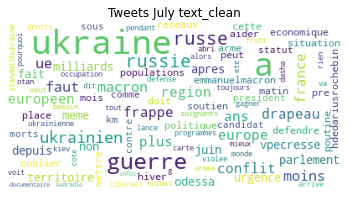

In [38]:
# nuage de mots par mois 
wordcloud_cols('month', 'text_clean', data )

# Nuage de mots - hashtags présents dans les tweets

In [39]:
data['hashtags']

16005                                           [#ukraine]
18745                                           [#ukraine]
19041                                           [#ukraine]
17592                                           [#ukraine]
16003                                       [#m, #ukraine]
                               ...                        
267                  [#russie, #ukraine, #ukraineinvasion]
15907                                  [#ukraine, #macron]
16037                                     [#oms, #ukraine]
3124     [#anonymous, #russie, #ukraine, #laguerre, #uk...
11934                                 [#poutine, #ukraine]
Name: hashtags, Length: 19834, dtype: object

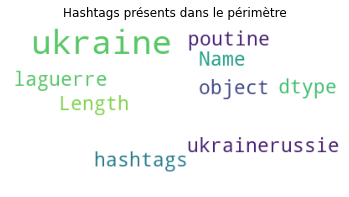

In [40]:
wordcloud_hash = WordCloud(background_color='white',
                          stopwords=stopwords_set,
                          max_words=100,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(data['hashtags'].explode()))

plt.title('Hashtags présents dans le périmètre')
plt.axis('off')
plt.imshow(wordcloud_hash)
plt.savefig("wordcloud_hashtags.png")

### <span style="color:#191970">2.3. Monitorer l'évolution du #Ukraine </span>

In [41]:
# on utilise "text" au lieu de "text_clean" pour trouver les #
data["Occurrence #Ukraine"] = data["text"].apply(
        lambda y: len([x.group() for x in re.finditer(r"#ukraine+", y)])
    )

In [42]:
temp = data.groupby("date")["Occurrence #Ukraine"].sum().reset_index()
temp

date  Occurrence #Ukraine
0    2022-02-01                   12
1    2022-02-02                   13
2    2022-02-03                   13
3    2022-02-04                   22
4    2022-02-05                    7
..          ...                  ...
146  2022-06-27                   77
147  2022-06-28                   60
148  2022-06-29                   42
149  2022-06-30                   43
150  2022-07-01                   53

[151 rows x 2 columns]

In [43]:
fig = px.line(temp,
              x='date',
              y="Occurrence #Ukraine",
              markers="True",
              title="Ocurrence #Ukraine",
              labels={
                     "Occurrence #Ukraine": "Ocurrence"
                 }
             ) 
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Ocurrence des mots clées telles que Marioupol, Crimée, Kiev...

In [44]:
table = data.copy(deep=True)

val = ['marioupol', 'crimee', 'kiev', 'louhansk', 'kramatorsk', 'lviv', 'kherson']

for elem in val:
    table[elem] = table["text_clean"].apply(
        lambda y: len([x.group() for x in re.finditer(f"{elem}+", y)])
    )

table[val].sum()

marioupol      466
crimee         106
kiev          1228
louhansk        22
kramatorsk      72
lviv           142
kherson        114
dtype: int64

In [45]:
tab2 = table.groupby("date")[val + ['Occurrence #Ukraine']].sum().reset_index()
tab2

date  marioupol  crimee  kiev  louhansk  kramatorsk  lviv  kherson  \
0    2022-02-01          0       0     2         0           0     0        0   
1    2022-02-02          0       0     0         0           0     0        0   
2    2022-02-03          0       1     1         0           0     0        0   
3    2022-02-04          0       0     2         0           0     0        0   
4    2022-02-05          0       0     0         0           0     0        0   
..          ...        ...     ...   ...       ...         ...   ...      ...   
146  2022-06-27          0       0     3         0           1     0        0   
147  2022-06-28          1       0     3         0           0     0        0   
148  2022-06-29          0       0     2         0           1     0        1   
149  2022-06-30          0       0     2         0           0     0        0   
150  2022-07-01          0       0     2         0           0     0        1   

     Occurrence #Ukraine  
0                     12  
1                     13  
2                     13  
3                     22  
4                      7  
..                   ...  
146                   77  
147                   60  
148                   42  
149                   43  
150                   53  

[151 rows x 9 columns]

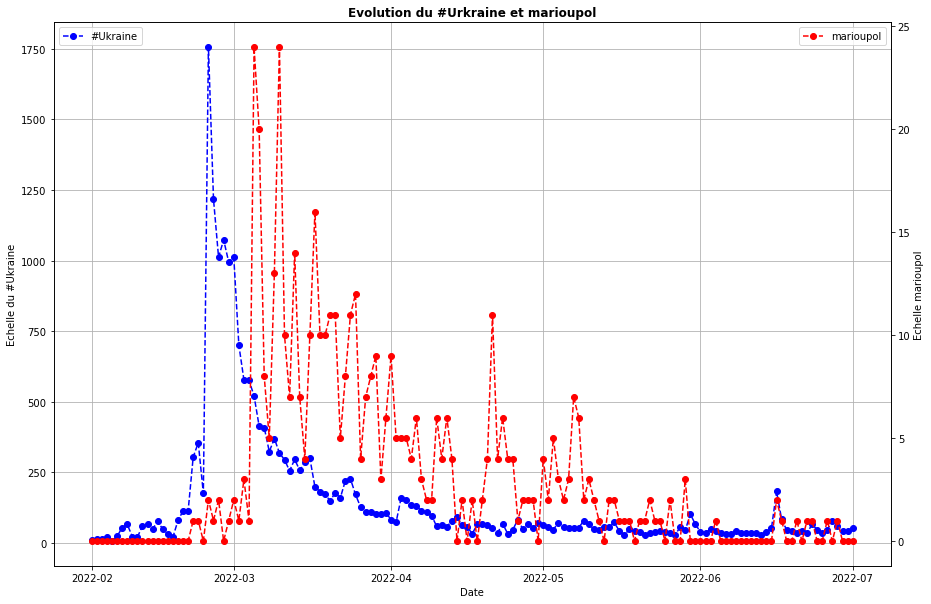

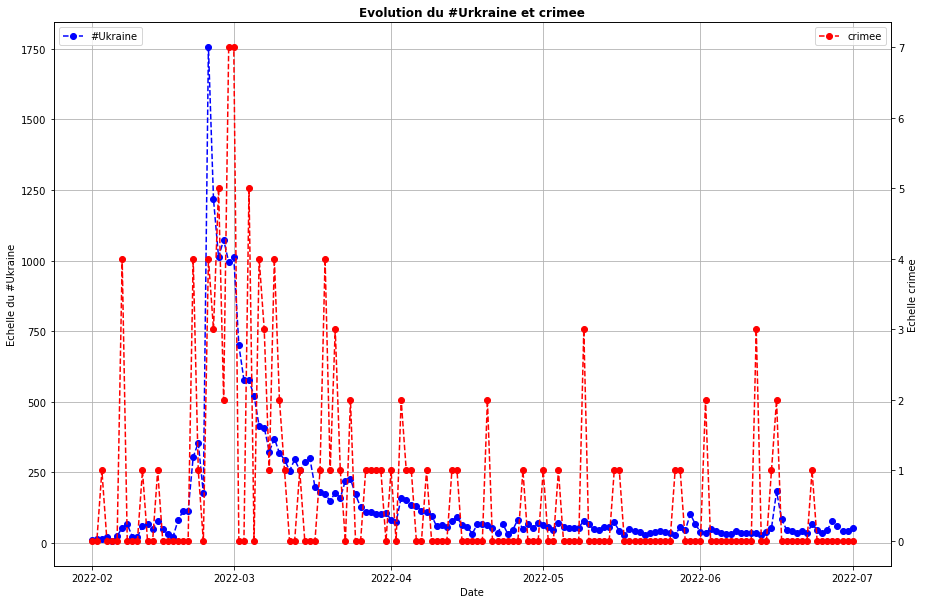

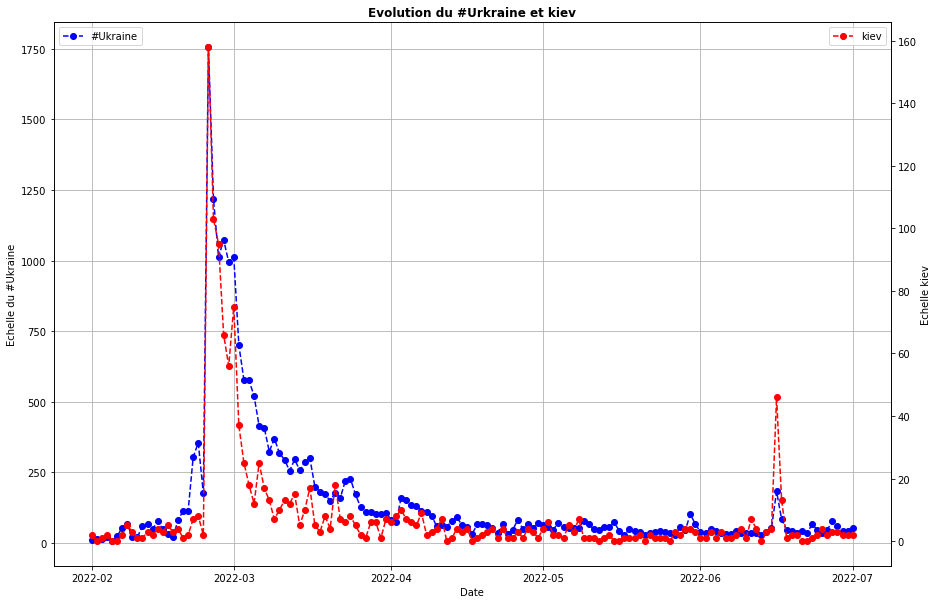

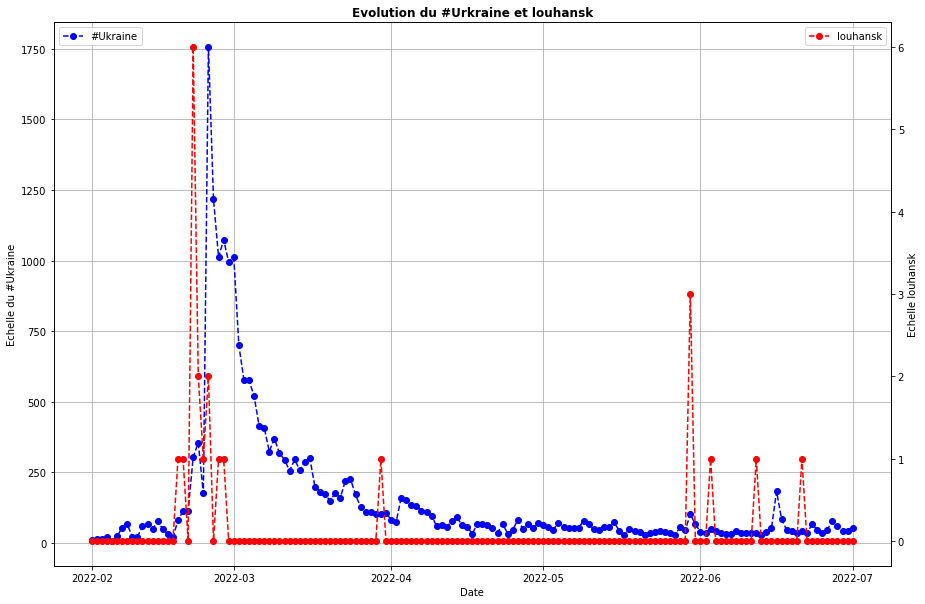

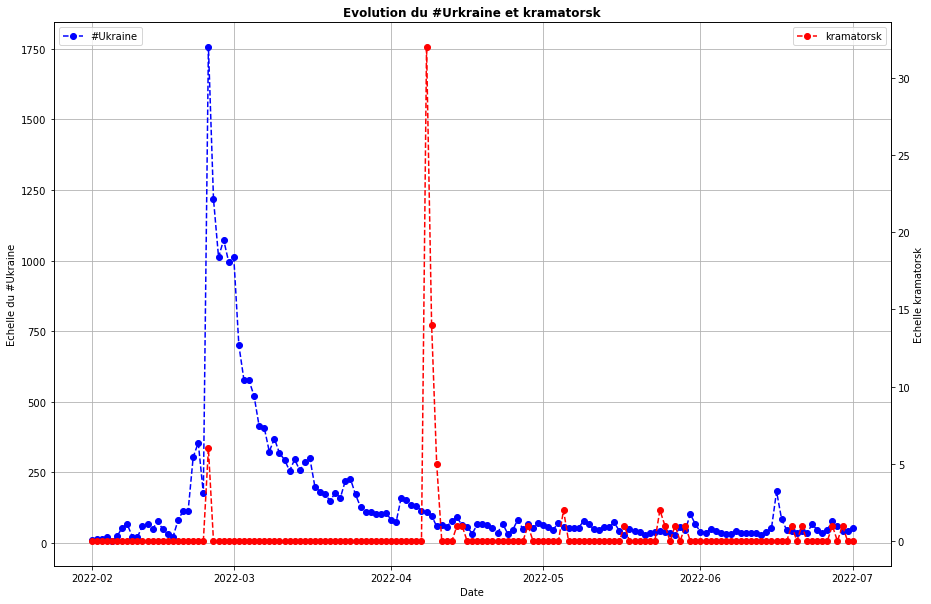

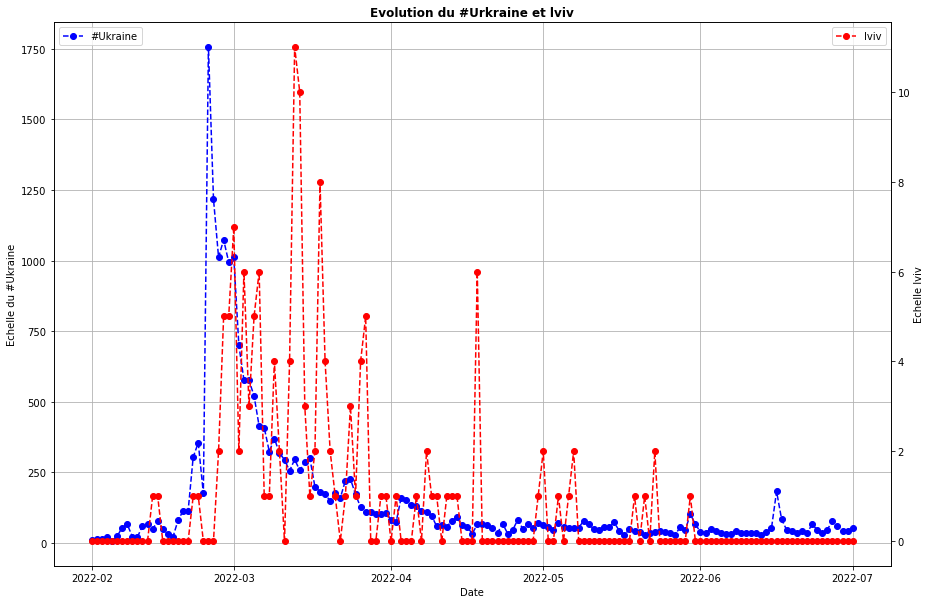

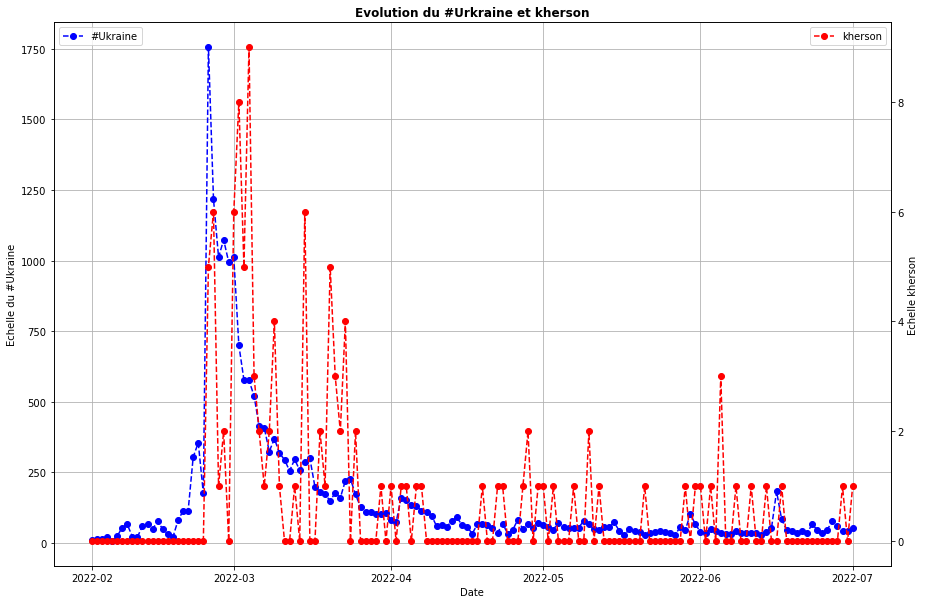

In [46]:
for elem in val:
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.plot(tab2['date'], tab2['Occurrence #Ukraine'], color = 'blue', linestyle='dashed', marker = 'o', label='#Ukraine')
    ax2 = ax.twinx()
    ax2.plot(tab2['date'], tab2[elem], color = 'red', linestyle='dashed', marker = 'o', label=elem)
    plt.title('Evolution du #Urkraine et '+elem, fontweight="bold")
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid()
    ax.set_xlabel("Date")
    ax.set_ylabel(r"Echelle du #Ukraine")
    ax2.set_ylabel(r"Echelle "+elem)
    plt.show()

### Mariopol
La bataille de Marioupol ou le siège de Marioupol est une bataille entre la Fédération de Russie et l'Ukraine qui a eu lieu du 24 février au 20 mai 2022, lors de l'invasion de l'Ukraine par la Russie, dans le cadre de l'offensive de l'Ukraine orientale, qui se déroule sous la forme d'un siège.

La ville de Marioupol, dans l'oblast de Donetsk en Ukraine, est revendiquée par la République populaire de Donetsk (RPD) autoproclamée. Au 28 mars 2022, la ville comptait le plus de morts depuis l'invasion russe.

On constate alors un accroissement de mentions "Marioupol" avec le hashtag Ukraine entre la période de février à avril 2022. En cette période, les tensions entre ces deux pays étaient de plus en plus forte. Les intentions de la Russie de siéger Marioupol en Ukraine était à son comble.

### Crimée
Depuis l'Annexion de la Crimée par la Russie en 2014 a toujours été un sujet mêlant inquiétude et conflit auprès de la population ukrainienne et russe. Par conséquent, ce n'est pas surprenant d'observer une liaison entre les tweets Ukraine et Crimée dans ce genre de conflit.

### Kiev
Kiev, capitale de l'Ukraine, fut la ville la plus citée dans les tweets en lien avec le hashtag Ukraine. Ville où siège le gouvernement urkainien, plus particulièrement l'ennemi cible de Vladimir Poutine (le président ukrainien Volodymyr Zelensky), serait assujettie à des attaques constantes depuis l'invasion russe en février/mars dernier.
Il n'est pas anodin de voir une augmentation de hashtag Kiev et Ukraine dans un même tweet, notamment sur des dates clés telles que :

Le **14/02/2022:** le plus d'hashtag Kiev avec Ukraine, contentieux géopolitique et réglement entre les présidents européens à Kiev et le président Vladimir Poutine.

Le **24/02/2022:** l'officielle invasion russe en Ukraine

En ce qui concerne les autres villes, **Louhansk, Kramatorsk et Lviv**, sont des villes voisines de la Russie (Est de l'Ukraine) qui ont été la première ligne de l'invasion russe. Elles sont également été au miliue du conflit énergétique pour l'Ukraine, puisque Kramatorsk est l'une des plus grandes villes industrielles de l'Ukraine.

En revanche, suite de l'annexion de la Crimée par la Russie en 2014, Kherson devient la capitale du gouvernement en exil de la république autonome de Crimée. En mars 2022, il y a eu la prise de Kherson.
Ainsi, elle fait donc partie des villes les plus mentionnées en lien avec le hashtag Ukraine en cette période de conflit géopolitique entre la Russie et l'Ukraine.

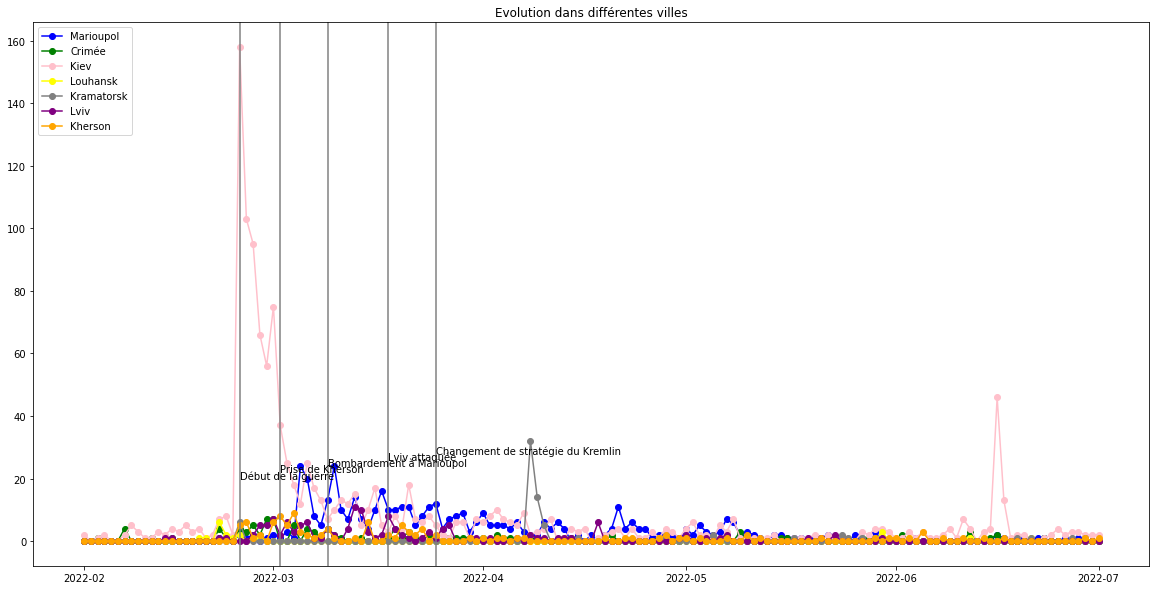

In [47]:
import datetime as dt
plt.figure(figsize=(20,10))

plt.plot(tab2['date'], tab2['marioupol'], color = 'blue', marker='o', label = 'Marioupol');
plt.plot(tab2['date'], tab2['crimee'], color = 'green', marker='o', label = 'Crimée');
plt.plot(tab2['date'], tab2['kiev'], color = 'pink', marker='o', label = 'Kiev');
plt.plot(tab2['date'], tab2['louhansk'], color = 'yellow', marker='o', label = 'Louhansk');
plt.plot(tab2['date'], tab2['kramatorsk'], color = 'gray', marker='o', label = 'Kramatorsk');
plt.plot(tab2['date'], tab2['lviv'], color = 'purple', marker='o', label = 'Lviv');
plt.plot(tab2['date'], tab2['kherson'], color = 'orange', marker='o', label = 'Kherson');

plt.title('Evolution dans différentes villes')
plt.axvline(dt.datetime(2022, 2, 24), color = 'gray')
plt.text(dt.datetime(2022, 2, 24), 20, 'Début de la guerre')

plt.axvline(dt.datetime(2022, 3, 2), color = 'gray')
plt.text(dt.datetime(2022, 3, 2), 22, 'Prise de Kherson')

plt.axvline(dt.datetime(2022, 3, 9), color = 'gray')
plt.text(dt.datetime(2022, 3, 9), 24, 'Bombardement à Marioupol')

plt.axvline(dt.datetime(2022, 3, 18), color = 'gray')
plt.text(dt.datetime(2022, 3, 18), 26, 'Lviv attaquée')

plt.axvline(dt.datetime(2022, 3, 25), color = 'gray')
plt.text(dt.datetime(2022, 3, 25), 28, 'Changement de stratégie du Kremlin')

plt.legend(loc = 'upper left')
plt.show()

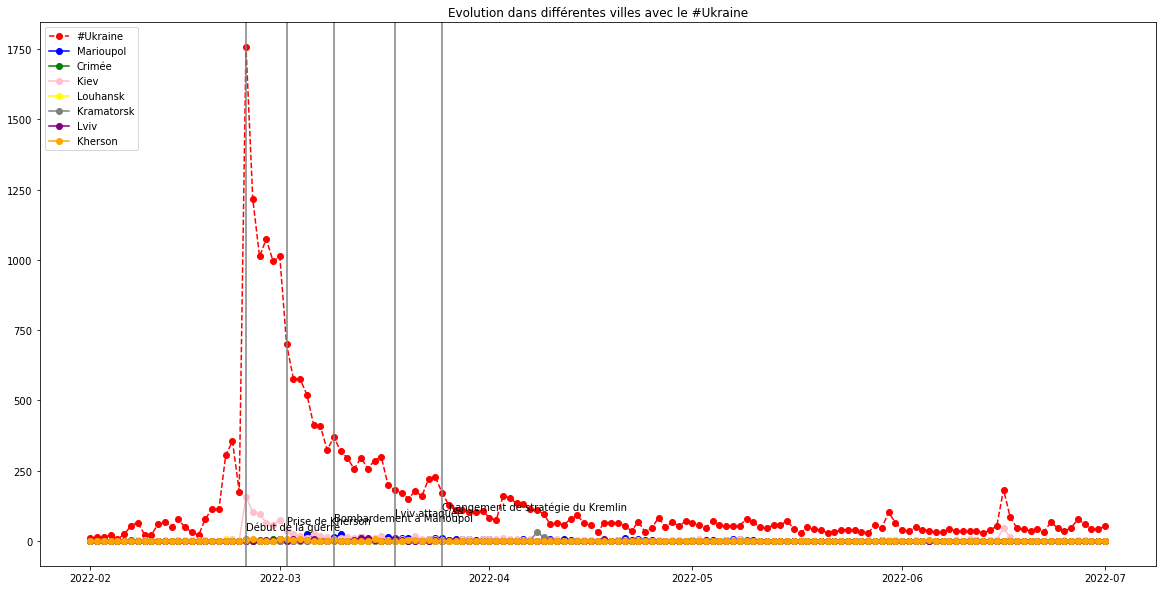

In [48]:
plt.figure(figsize=(20,10))

plt.plot(tab2['date'], tab2['Occurrence #Ukraine'], color = 'red', linestyle='dashed', marker='o', label = '#Ukraine');
plt.plot(tab2['date'], tab2['marioupol'], color = 'blue', marker='o', label = 'Marioupol');
plt.plot(tab2['date'], tab2['crimee'], color = 'green', marker='o', label = 'Crimée');
plt.plot(tab2['date'], tab2['kiev'], color = 'pink', marker='o', label = 'Kiev');
plt.plot(tab2['date'], tab2['louhansk'], color = 'yellow', marker='o', label = 'Louhansk');
plt.plot(tab2['date'], tab2['kramatorsk'], color = 'gray', marker='o', label = 'Kramatorsk');
plt.plot(tab2['date'], tab2['lviv'], color = 'purple', marker='o', label = 'Lviv');
plt.plot(tab2['date'], tab2['kherson'], color = 'orange', marker='o', label = 'Kherson');

plt.title('Evolution dans différentes villes avec le #Ukraine')

plt.axvline(dt.datetime(2022, 2, 24), color = 'gray')
plt.text(dt.datetime(2022, 2, 24), 40, 'Début de la guerre')

plt.axvline(dt.datetime(2022, 3, 2), color = 'gray')
plt.text(dt.datetime(2022, 3, 2), 60, 'Prise de Kherson')

plt.axvline(dt.datetime(2022, 3, 9), color = 'gray')
plt.text(dt.datetime(2022, 3, 9), 70, 'Bombardement à Marioupol')

plt.axvline(dt.datetime(2022, 3, 18), color = 'gray')
plt.text(dt.datetime(2022, 3, 18), 90, 'Lviv attaquée')

plt.axvline(dt.datetime(2022, 3, 25), color = 'gray')
plt.text(dt.datetime(2022, 3, 25), 110, 'Changement de stratégie du Kremlin')

plt.legend(loc = 'upper left')
plt.show()

### <span style="color:#191970">Autres hashtags présents dans les tweets</span>

In [49]:
# Hastags
data['hashtags_pertw'] = data["hashtags"].apply(lambda x: len(x))
hashtags_list = data.hashtags.explode()
hashtags_list.value_counts()

#ukraine      20076
#russie        3430
#poutine       2011
#macron        1069
#zelensky       658
              ...  
#roquettes        1
#label            1
#victoire         1
#fondapol         1
#langues          1
Name: hashtags, Length: 4565, dtype: int64

In [50]:
hts = hashtags_list.value_counts().reset_index().iloc[:20]
hts

fig_autres_htg = px.bar(hts,
              x='hashtags',
              y='index',
              orientation='h',
              title='Top 20 des hashtags',
              labels={
                     "index": "",
                     "hashtags": ""
                 }
             )
fig_autres_htg.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### <span style="color:#191970">2.4. Statistiques des comptes officiels du Gouvernement</span>

#### <span style="color:#191970">Evolution nb de tweets</span>

In [51]:
comptes_gouv = ["Interieur_Gouv", "PoliceNationale", "Gendarmerie", "SecCivileFrance", "Prefpolice", "PorteParoleMI", "gouvernementFR"]

In [52]:
df_gouv = data[data['username'].isin(comptes_gouv)]

Peu de tweets présents dans le périmètre (34)

In [53]:
df_gouv.shape

(34, 21)

In [54]:
df_gouv.reset_index(inplace=True, drop=True)

In [55]:
df_gouv.tail()

datetime             tweet_id  \
29 2022-03-22 11:38:25+00:00  1506233836132261893   
30 2022-03-23 17:06:43+00:00  1506678841103863808   
31 2022-03-27 11:17:46+00:00  1508040576628928519   
32 2022-03-08 17:31:04+00:00  1501249151761268739   
33 2022-03-26 20:08:31+00:00  1507811758202929154   

                                                 text         username  \
29  solidarité avec l’#ukraine 🇺🇦🤝🇫🇷\r\ndépart dem...  SecCivileFrance   
30  #solidarité #ukraine 🇺🇦🤝🇫🇷 le convoi à destina...  SecCivileFrance   
31  #solidarité 🇺🇦🤝🇫🇷 départ ce matin pour l’#ukra...  SecCivileFrance   
32  [#ukraine] pensées fraternelles et solidaires ...  PoliceNationale   
33  #solidarité #ukraine🇺🇦🤝🇫🇷 après 2 200 kilomètr...  SecCivileFrance   

    like_count  retweet_count  reply_count  quote_count  \
29         448            144           14           16   
30         494            119            7            8   
31         504            108            7            8   
32         609             90           68            4   
33        1241            333           29           26   

                             hashtags    arrobas  ... language        date  \
29                         [#ukraine]         []  ...       fr  2022-03-22   
30             [#solidarit, #ukraine]         []  ...       fr  2022-03-23   
31             [#solidarit, #ukraine]  [@cdcmae]  ...       fr  2022-03-27   
32                         [#ukraine]         []  ...       fr  2022-03-08   
33  [#solidarit, #ukraine, #roumanie]         []  ...       fr  2022-03-26   

   day  month      time hour  minute     tranches_like Occurrence #Ukraine  \
29  22      3  11:38:25   11      38  [201-1000 likes]                   1   
30  23      3  17:06:43   17       6  [201-1000 likes]                   1   
31  27      3  11:17:46   11      17  [201-1000 likes]                   1   
32   8      3  17:31:04   17      31  [201-1000 likes]                   1   
33  26      3  20:08:31   20       8       >1000 likes                   1   

    hashtags_pertw  
29               1  
30               2  
31               2  
32               1  
33               3  

[5 rows x 21 columns]

In [56]:
df_gouv.tail()

datetime             tweet_id  \
29 2022-03-22 11:38:25+00:00  1506233836132261893   
30 2022-03-23 17:06:43+00:00  1506678841103863808   
31 2022-03-27 11:17:46+00:00  1508040576628928519   
32 2022-03-08 17:31:04+00:00  1501249151761268739   
33 2022-03-26 20:08:31+00:00  1507811758202929154   

                                                 text         username  \
29  solidarité avec l’#ukraine 🇺🇦🤝🇫🇷\r\ndépart dem...  SecCivileFrance   
30  #solidarité #ukraine 🇺🇦🤝🇫🇷 le convoi à destina...  SecCivileFrance   
31  #solidarité 🇺🇦🤝🇫🇷 départ ce matin pour l’#ukra...  SecCivileFrance   
32  [#ukraine] pensées fraternelles et solidaires ...  PoliceNationale   
33  #solidarité #ukraine🇺🇦🤝🇫🇷 après 2 200 kilomètr...  SecCivileFrance   

    like_count  retweet_count  reply_count  quote_count  \
29         448            144           14           16   
30         494            119            7            8   
31         504            108            7            8   
32         609             90           68            4   
33        1241            333           29           26   

                             hashtags    arrobas  ... language        date  \
29                         [#ukraine]         []  ...       fr  2022-03-22   
30             [#solidarit, #ukraine]         []  ...       fr  2022-03-23   
31             [#solidarit, #ukraine]  [@cdcmae]  ...       fr  2022-03-27   
32                         [#ukraine]         []  ...       fr  2022-03-08   
33  [#solidarit, #ukraine, #roumanie]         []  ...       fr  2022-03-26   

   day  month      time hour  minute     tranches_like Occurrence #Ukraine  \
29  22      3  11:38:25   11      38  [201-1000 likes]                   1   
30  23      3  17:06:43   17       6  [201-1000 likes]                   1   
31  27      3  11:17:46   11      17  [201-1000 likes]                   1   
32   8      3  17:31:04   17      31  [201-1000 likes]                   1   
33  26      3  20:08:31   20       8       >1000 likes                   1   

    hashtags_pertw  
29               1  
30               2  
31               2  
32               1  
33               3  

[5 rows x 21 columns]

In [57]:
#evolution nb de tweets par jour du Gouvernement (qui ont été retweetés au moins 10 fois)

#tpd=nb tweets per day
tpd_gouv = df_gouv.groupby("date")["tweet_id"].count().reset_index()
tpd_gouv.sort_values(by="tweet_id", ascending=False)

date  tweet_id
2   2022-02-27         2
3   2022-03-01         2
7   2022-03-08         2
12  2022-03-22         2
18  2022-04-14         2
14  2022-03-24         2
17  2022-03-30         2
0   2022-02-24         1
16  2022-03-27         1
25  2022-06-20         1
24  2022-06-07         1
23  2022-05-21         1
22  2022-05-13         1
21  2022-05-10         1
20  2022-04-21         1
19  2022-04-19         1
13  2022-03-23         1
15  2022-03-26         1
1   2022-02-25         1
11  2022-03-17         1
10  2022-03-16         1
9   2022-03-14         1
8   2022-03-10         1
6   2022-03-04         1
5   2022-03-03         1
4   2022-03-02         1
26  2022-06-23         1

In [58]:
#evolution du nb de tweets par jour du Gouvernement
fig = px.line(tpd_gouv,
              x="date",
              y="tweet_id",
              title='Evolution du nb de tweets par jour du Gouvernement',
              labels={
                     "tweet_id": "Nb de tweets"
                 }
             )
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Peu de tweets officiels (retweetés au moins 10 fois) par jour : entre 1 et 2 par jour.

27/02 : Russie menace nucléaire / UE envoie des armes à l'Ukraine <br>
01/03 : Convoi militaire de la Russie vers Kiev <br>
08/03 : Chine encourage cessez le feu / sanctions augmentent<br>
22/03 : Les Etats-Unis et l'Europe vont infliger de nouvelles sanctions à la Russie <br>
24/03 : changement de stratégie du Kremlin<br>
30/03 : "régime de silence", soit un cessez-le-feu local, dans le port assiégé de Marioupol. Cette mesure doit permettre d'ouvrir un couloir humanitaire<br>
14/04 : le « Moskva » coule<br>


#### <span style="color:#191970">Stats describe - variables num</span>

In [59]:
df_gouv[count_var].describe()

like_count  retweet_count  reply_count  quote_count
count    34.000000      34.000000    34.000000    34.000000
mean    217.500000      63.764706    35.764706     4.882353
std     233.622364      58.182606    66.920151     5.197696
min      32.000000      14.000000     0.000000     0.000000
25%      71.000000      30.000000     4.250000     2.000000
50%     143.000000      50.000000     8.000000     3.500000
75%     258.750000      76.000000    24.500000     6.000000
max    1241.000000     333.000000   311.000000    26.000000

En moyenne un tweet du Gouvernement est liké 217 fois et peut aller jusqu'à un maximum de 1241 likes. <br>
Par ailleurs, un tweet est retweeté 64 fois en moyenne et peut être retweeté au maximum jusqu'à 333 fois.<br>

#### <span style="color:#191970">Distributions - variables num</span>

Text(0.5, 0.98, 'Statistiques de base des tweets du Gouvernement')

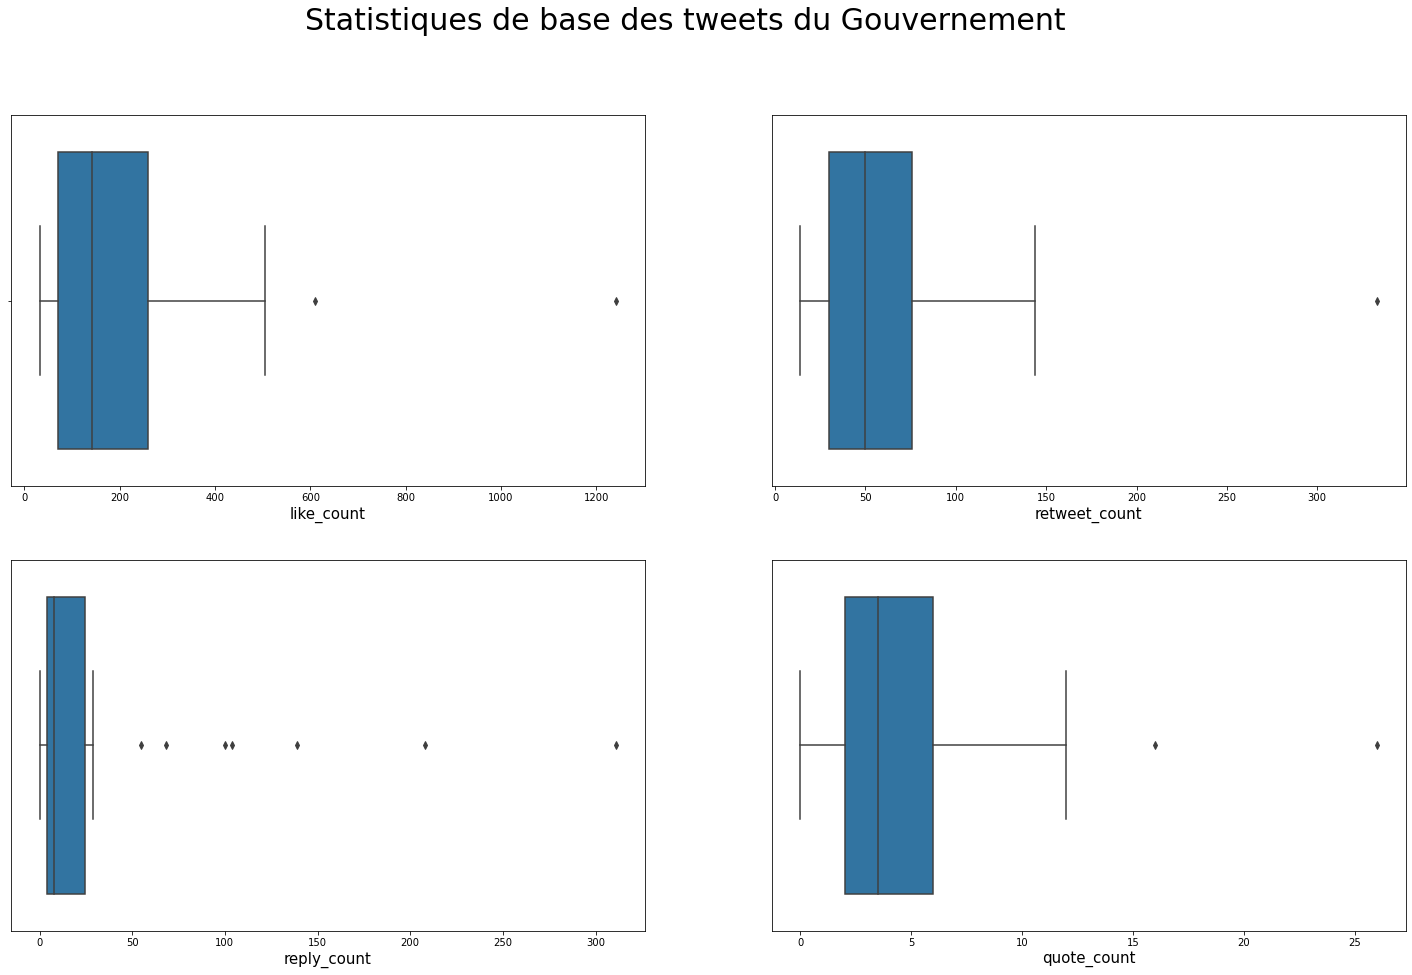

In [60]:
#Boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))

ax1 = sns.boxplot(x="like_count", data=df_gouv, ax=axes[0,0])
ax2 = sns.boxplot(x="retweet_count", data=df_gouv, ax=axes[0,1])
ax3 = sns.boxplot(x="reply_count", data=df_gouv, ax=axes[1,0])
ax4 = sns.boxplot(x="quote_count", data=df_gouv, ax=axes[1,1])

ax1.set_ylabel('', fontsize=15)
ax1.set_xlabel('like_count', fontsize=15)

ax2.set_ylabel('', fontsize=15)
ax2.yaxis.set_visible(False)
ax2.set_xlabel('retweet_count', fontsize=15)

ax3.set_ylabel('', fontsize=15)
ax3.yaxis.set_visible(False)
ax3.set_xlabel('reply_count', fontsize=15)

ax4.set_ylabel('', fontsize=15)
ax4.yaxis.set_visible(False)
ax4.set_xlabel('quote_count', fontsize=15)
fig.suptitle('Statistiques de base des tweets du Gouvernement', fontsize=30)

In [61]:
df_gouv[df_gouv['like_count']>600].head()

datetime             tweet_id  \
32 2022-03-08 17:31:04+00:00  1501249151761268739   
33 2022-03-26 20:08:31+00:00  1507811758202929154   

                                                 text         username  \
32  [#ukraine] pensées fraternelles et solidaires ...  PoliceNationale   
33  #solidarité #ukraine🇺🇦🤝🇫🇷 après 2 200 kilomètr...  SecCivileFrance   

    like_count  retweet_count  reply_count  quote_count  \
32         609             90           68            4   
33        1241            333           29           26   

                             hashtags arrobas  ... language        date day  \
32                         [#ukraine]      []  ...       fr  2022-03-08   8   
33  [#solidarit, #ukraine, #roumanie]      []  ...       fr  2022-03-26  26   

    month      time hour  minute     tranches_like Occurrence #Ukraine  \
32      3  17:31:04   17      31  [201-1000 likes]                   1   
33      3  20:08:31   20       8       >1000 likes                   1   

    hashtags_pertw  
32               1  
33               3  

[2 rows x 21 columns]

In [62]:
df_gouv[df_gouv['retweet_count']>300].head()

datetime             tweet_id  \
33 2022-03-26 20:08:31+00:00  1507811758202929154   

                                                 text         username  \
33  #solidarité #ukraine🇺🇦🤝🇫🇷 après 2 200 kilomètr...  SecCivileFrance   

    like_count  retweet_count  reply_count  quote_count  \
33        1241            333           29           26   

                             hashtags arrobas  ... language        date day  \
33  [#solidarit, #ukraine, #roumanie]      []  ...       fr  2022-03-26  26   

    month      time hour  minute  tranches_like Occurrence #Ukraine  \
33      3  20:08:31   20       8    >1000 likes                   1   

    hashtags_pertw  
33               3  

[1 rows x 21 columns]

Les tweets les plus populaires en termes de like et retweet sont ceux qui parlent de solidarité

#### <span style="color:#191970">Répartition des tweets/tranches de like</span>

In [63]:
tranches_like_gouv = [
    (df_gouv['like_count'] > 500) ,
    (df_gouv['like_count'] > 200) & (df_gouv['like_count'] <=500),
    (df_gouv['like_count'] > 100) & (df_gouv['like_count'] <=200),
    (df_gouv['like_count'] > 0) & (df_gouv['like_count'] <=100),
    (df_gouv['like_count'] == 0)]
choicelist_gouv = [">500 likes", "[201-500 likes]", "[101-200 likes]", "[1-100 likes]", "0 like"]
df_gouv['tranches_like'] = np.select(tranches_like_gouv, choicelist_gouv, default='Not Specified')
df_gouv = df_gouv.sort_values(by=["like_count"], ascending=True)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_16080\4247361917.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
tmp = df_gouv["tranches_like"].value_counts().sort_values(ascending=False).reset_index()
tmp

index  tranches_like
0    [1-100 likes]             13
1  [201-500 likes]             10
2  [101-200 likes]              8
3       >500 likes              3

In [65]:
#Histogramme de répartition des tweets du Gouvernement par tranche de like
fig = px.bar(tmp,
             x="tranches_like",
             y="index",
            title="Répartition des tweets du Gouvernement par tranche de like",
            labels={
                     "index": "",
                     "tranches_like": "Nb de tweets"
                 })
fig.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### <span style="color:#191970">Nuages de mots</span>

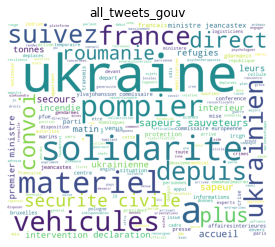

In [66]:
stopwords_set = set(stopwords.words('french')) #nltk
    
wordcloud_gouv = WordCloud(background_color='white',
                           collocations=True, # Inclu les bigrammes -> Deux mots cotes à cotes, même couleur même taille
                           width=1200,
                           height=1000,
                           stopwords=stopwords_set).generate(" ".join(df_gouv['text_clean']))

plt.axis('off')
plt.title('all_tweets_gouv')
plt.imshow(wordcloud_gouv)
plt.savefig("wordcloud_general_gouv.png")

Mots importants : Solidarité, réfugiés, sécurité civile, matériel, Roumanie, pompier, sapeurs sauveteurs, véhicules, convoi, secours, Affaires intérieures

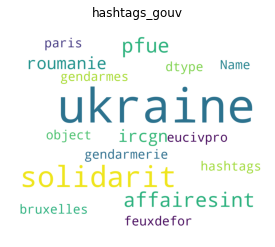

In [67]:
gouv_hash = WordCloud(background_color='white',
                           collocations=True, # Inclu les bigrammes 
                           width=1200,
                           height=1000,
                           stopwords=stopwords_set).generate(str(df_gouv['hashtags'].explode()))

plt.axis('off')
plt.title('hashtags_gouv')
plt.imshow(gouv_hash)
plt.savefig("wordcloud_hashtags_gouv.png")

Mots importants : Solidarité, Roumanie, Affaires intérieures, Gendarmerie, PFUE<br>
C'est vraiment la solidarité qui ressort des tweets du Gouvernement. Entre les tweets les plus populaires qui parlent de solidarité et les nuages de mots qui font ressortir à chaque fois ce terme de Solidarité.

#### <span style="color:#191970">Evolution du nb de Hashtag SOLIDARITE</span>

In [68]:
df_gouv["hash_solidarite"] = df_gouv["text"].apply(
        lambda y: len([x.group() for x in re.finditer(r"#solidar+", y)])
    )

In [69]:
df_gouv.to_csv('./df_gouv.csv', index=False)

In [70]:
df_gouv[["hashtags","text", "hash_solidarite"]].tail(9)

hashtags  \
25                                    [#ukraine]   
26                                    [#ukraine]   
27                            [#ukraine, #ircgn]   
28  [#ukraine, #gendarmes, #ircgn, #gendarmerie]   
29                                    [#ukraine]   
30                        [#solidarit, #ukraine]   
31                        [#solidarit, #ukraine]   
32                                    [#ukraine]   
33             [#solidarit, #ukraine, #roumanie]   

                                                 text  hash_solidarite  
25  #ukraine | déclaration du président de la répu...                0  
26  en direct | situation en #ukraine : suivez la ...                0  
27  #ukraine • sur le terrain, les gendarmes de l'...                0  
28  #ukraine depuis plus de deux mois, des #gendar...                0  
29  solidarité avec l’#ukraine 🇺🇦🤝🇫🇷\r\ndépart dem...                0  
30  #solidarité #ukraine 🇺🇦🤝🇫🇷 le convoi à destina...                1  
31  #solidarité 🇺🇦🤝🇫🇷 départ ce matin pour l’#ukra...                1  
32  [#ukraine] pensées fraternelles et solidaires ...                0  
33  #solidarité #ukraine🇺🇦🤝🇫🇷 après 2 200 kilomètr...                1

In [71]:
#nb de hashtags "solidarité" par jour
hash_solidarite=df_gouv.groupby("date")["hash_solidarite"].sum().reset_index()
display(hash_solidarite)

date  hash_solidarite
0   2022-02-24                0
1   2022-02-25                0
2   2022-02-27                0
3   2022-03-01                0
4   2022-03-02                0
5   2022-03-03                0
6   2022-03-04                0
7   2022-03-08                0
8   2022-03-10                0
9   2022-03-14                0
10  2022-03-16                0
11  2022-03-17                0
12  2022-03-22                0
13  2022-03-23                1
14  2022-03-24                1
15  2022-03-26                1
16  2022-03-27                1
17  2022-03-30                0
18  2022-04-14                1
19  2022-04-19                1
20  2022-04-21                1
21  2022-05-10                1
22  2022-05-13                0
23  2022-05-21                0
24  2022-06-07                0
25  2022-06-20                0
26  2022-06-23                0

In [72]:
#Evolution du nb de hashtag "solidarité" dans les tweets du Gouvernement
fig5 = px.line(hash_solidarite,
               x='date',
               y="hash_solidarite",
              title="Evolution du nb de '#solidarité' dans les tweets du Gouvernement"
              )
fig5.show()

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Les pics conrrespondent avec les départs des 3 convois de Solidarité nationale envers l'Ukraine, acheminant des dons de matériels et véhicules de secours. <br>
23 au 27 mars : 1er convoi<br>
14 au 21 avril : 2nd convoi<br>
10 mai : 3ème convoi

## <span style="color:#191970">3. Pré processing</span>

Import des données après le preprocessing qui comprend les étapes suivantes : 
- Refiltre sur tweets restants en anglais
- supprime les tweets repetés (même username et contenu du tweet, peu importe la date)
- supprime les liens html
- supprime des stopwords dans le dictionnaire nlk et ceux que nous avons ajouté
- applique les méthodes de lemmatisation et stemming 
- creé des bigrames et des trigrams

In [17]:
raw_data = read_files(os.path.join(path, "data/min_retweet_3/"))
print(raw_data.shape)
# drop repeated tweets no matter the date
raw_data = raw_data.drop_duplicates(["text", "username"])
print(f"Shape after dropping duplicates {raw_data.shape}")

# format dates
data = transform_dates(raw_data)
# clean tweets
df_prepro = preprocessing(data)

C:\Users\vnarv\PycharmProjects\twitter_text_mining
(19939, 8)
Shape after dropping duplicates (19933, 8)
Nb of tweets detected in other language language
af    5 
ca    9 
cs    2 
da    3 
de    11
en    68
es    3 
et    10
fi    17
hr    3 
id    4 
it    20
lt    7 
lv    1 
nl    6 
no    14
pl    1 
pt    1 
ro    3 
sk    1 
sl    3 
sv    1 
sw    1 
Name: tweet_id, dtype: int64
                                                                                                                                                                                                                                                  text_clean  \
93     desescaladez vladimir par cocoboer ukraine                                                                                                                                                                                                              
192   spanish minister of foreign affairs jose manuel albares en route to ukraine via gdarkconrad 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vnarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape before dropping dups: (19739, 18)
Shape after dropping dups: (19531, 18)


In [89]:
df_prepro.shape

(19534, 24)

In [90]:
raw_data.shape

(19933, 17)

In [91]:
df_prepro.head()

datetime             tweet_id  \
0 2022-02-01 08:44:30+00:00  1488433061196812291   
1 2022-02-01 09:42:34+00:00  1488447673883676672   
2 2022-02-01 12:43:38+00:00  1488493240475078658   
3 2022-02-01 13:20:13+00:00  1488502446771081216   
4 2022-02-01 13:56:13+00:00  1488511509961527302   

                                                text         username  \
0  voilà l'info, malheureusement très peu reprise...        tcabarrus   
1  #ukraine face à poutine ... macron hausse le t...          lapin47   
2  crise en #ukraine : « emmanuel #macron et vlad...  FaireEnsembleEM   
3  la #russie c'est l'équivalent du pib de l'ital...  BrunoRetailleau   
4  crise en #ukraine : voilà pourquoi il faut sor...      f_philippot   

   like_count  retweet_count  reply_count  quote_count        date  day  ...  \
0          58             33            2            0  2022-02-01    1  ...   
1         230            103           36           24  2022-02-01    1  ...   
2          63             17            6            0  2022-02-01    1  ...   
3          59             29            9            1  2022-02-01    1  ...   
4         745            236           34            5  2022-02-01    1  ...   

                                            hashtags          arrobas  \
0  [#medias, #emmanuelmacron, #vladimirpoutine, #...               []   
1                                         [#ukraine]               []   
2                      [#ukraine, #macron, #poutine]  [@gabrielattal]   
3                         [#russie, #kiev, #ukraine]               []   
4                                         [#ukraine]               []   

                                          text_clean  language  \
0  malheureusement tres peu reprise medias entret...        fr   
1                         face poutine macron hausse        fr   
2  crise macron poutine reparles hier dialogue ec...        fr   
3  equivalent pib italie attention sanctions pour...        fr   
4  crise pourquoi sortir piege atlantiste refuser...        fr   

                                           text_stem  \
0  malheur tre peu repris medi entretien telephon...   
1                            fac poutin macron hauss   
2  cris macron poutin reparl hi dialogu echang no...   
3  equivalent pib ital attent sanction pourr rece...   
4  cris pourquoi sort pieg atlant refus quitt ota...   

                                    text_stem_bigram  \
0  malheur_tre tre_peu peu_repris repris_medi med...   
1              fac_poutin poutin_macron macron_hauss   
2  cris_macron macron_poutin poutin_reparl reparl...   
3  equivalent_pib pib_ital ital_attent attent_san...   
4  cris_pourquoi pourquoi_sort sort_pieg pieg_atl...   

                                   text_stem_trigram  \
0  malheur_tre_peu tre_peu_repris peu_repris_medi...   
1              fac_poutin_macron poutin_macron_hauss   
2  cris_macron_poutin macron_poutin_reparl poutin...   
3  equivalent_pib_ital pib_ital_attent ital_atten...   
4  cris_pourquoi_sort pourquoi_sort_pieg sort_pie...   

                                          text_lemma  \
0  malheureusement tres peu reprise media entreti...   
1                         face poutine macron hausse   
2  crise macron poutine reparles hier dialogue ec...   
3  equivalent pib italie attention sanction pourr...   
4  crise pourquoi sortir piege atlantiste refuser...   

                                   text_lemma_bigram  \
0  malheureusement_tres tres_peu peu_reprise repr...   
1          face_poutine poutine_macron macron_hausse   
2  crise_macron macron_poutine poutine_reparles r...   
3  equivalent_pib pib_italie italie_attention att...   
4  crise_pourquoi pourquoi_sortir sortir_piege pi...   

                                  text_lemma_trigram  
0  malheureusement_tres_peu tres_peu_reprise peu_...  
1          face_poutine_macron poutine_macron_hausse  
2  crise_macron_poutine macron_poutine_reparles p...  
3  equivalent_pib_italie pib_italie_attention

###  Nuage de mots après preprocessing

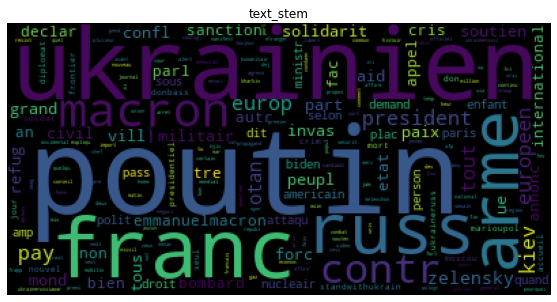

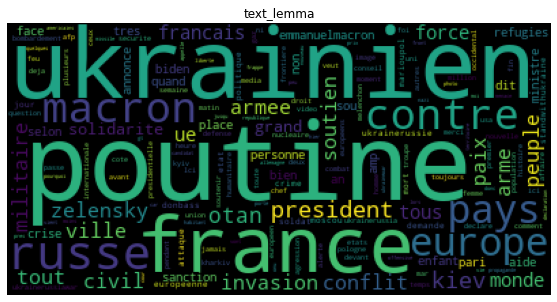

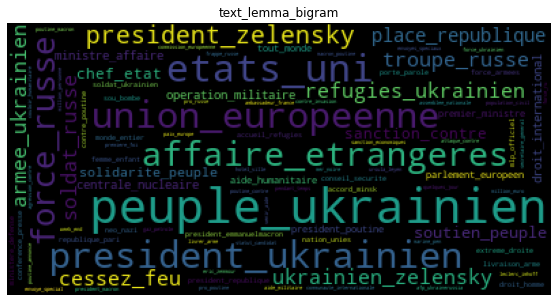

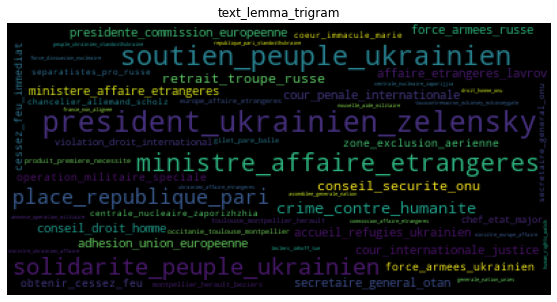

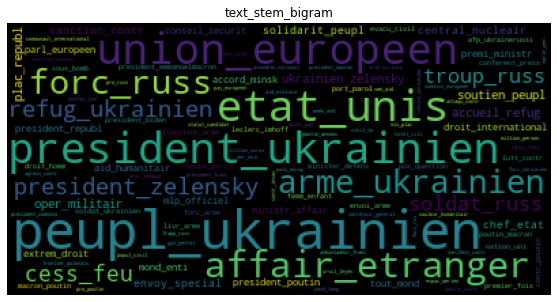

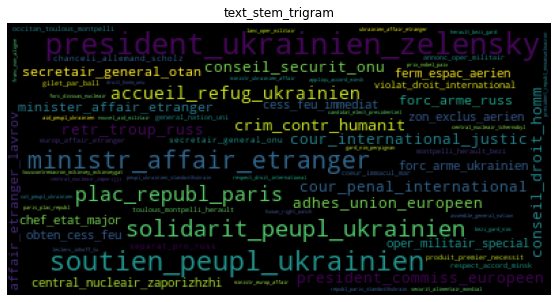

In [92]:
new_cols_prepro = ["text_stem", "text_lemma",
        "text_lemma_bigram", "text_lemma_trigram",
        "text_stem_bigram", "text_stem_trigram"]
for method in new_cols_prepro:
    words_t = ''
    for i in df_prepro[method]:
        try:
            words_t += '{} '.format(i.lower())
        except AttributeError:
            pass
    wd = pd.DataFrame(Counter(words_t.split()).most_common(), columns=['word', 'frequency_total'])
    tuples = [tuple(x) for x in wd.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.subplots(figsize=(10, 5)) 
    plt.imshow(wordcloud)
    plt.title(f"{method}") 
    plt.axis("off")
    plt.show()

### Fréquence des ngrames

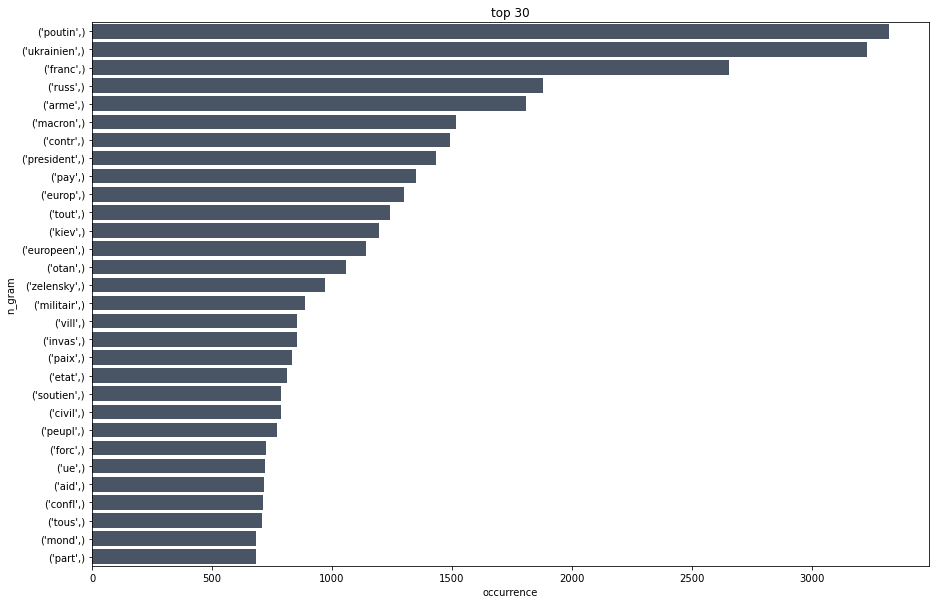

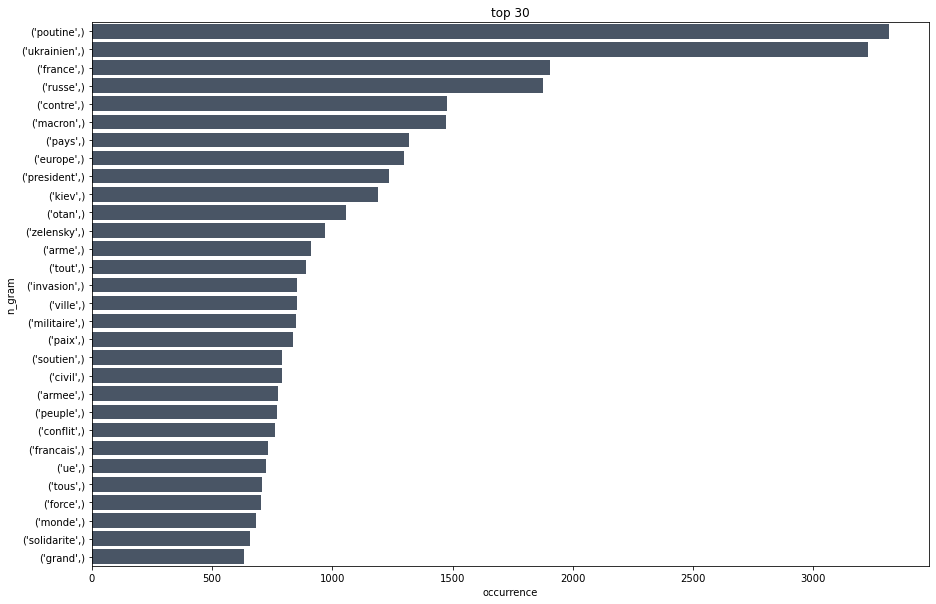

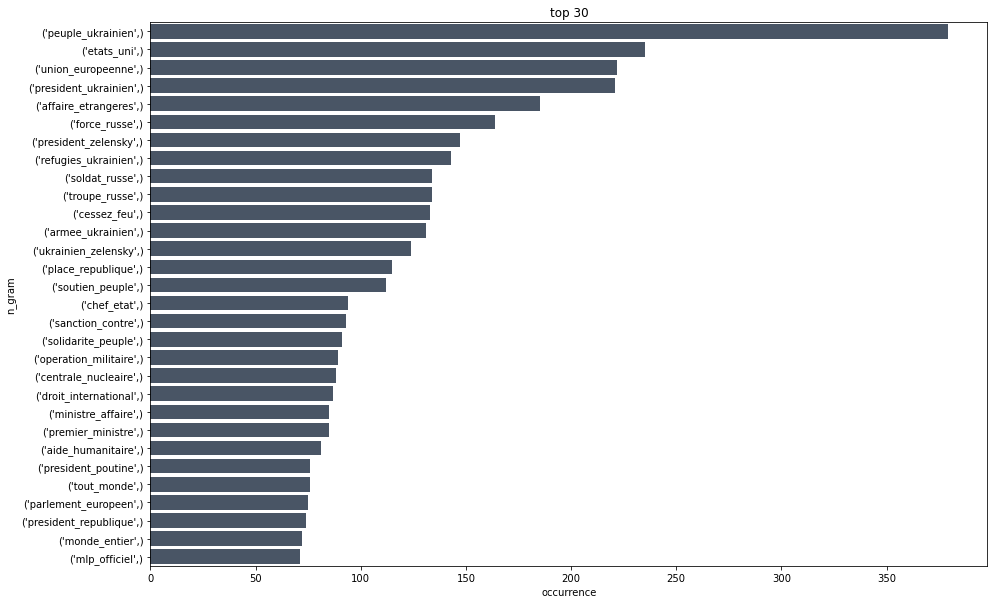

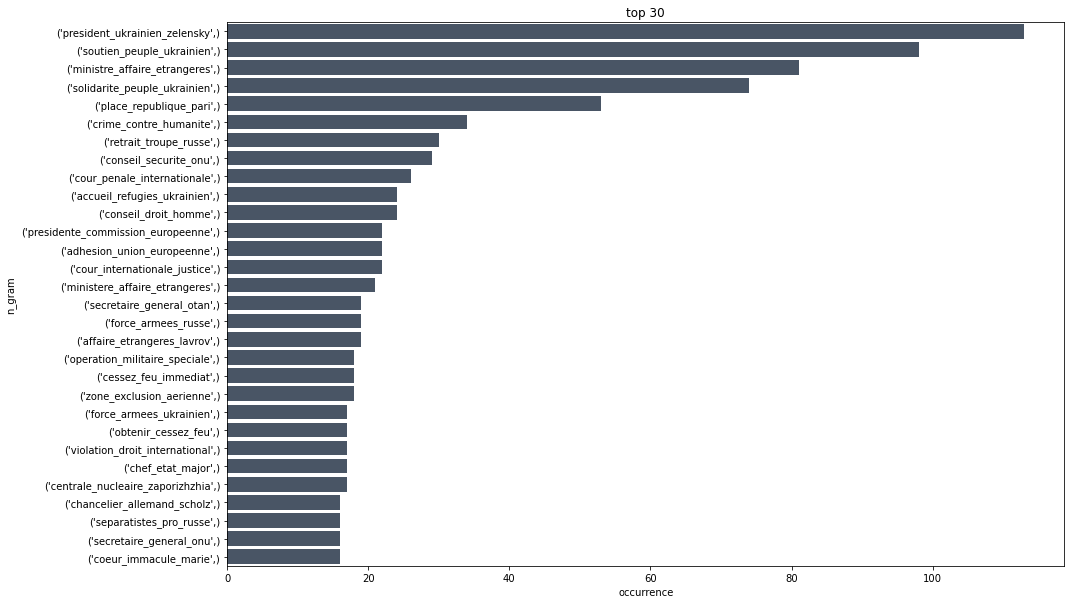

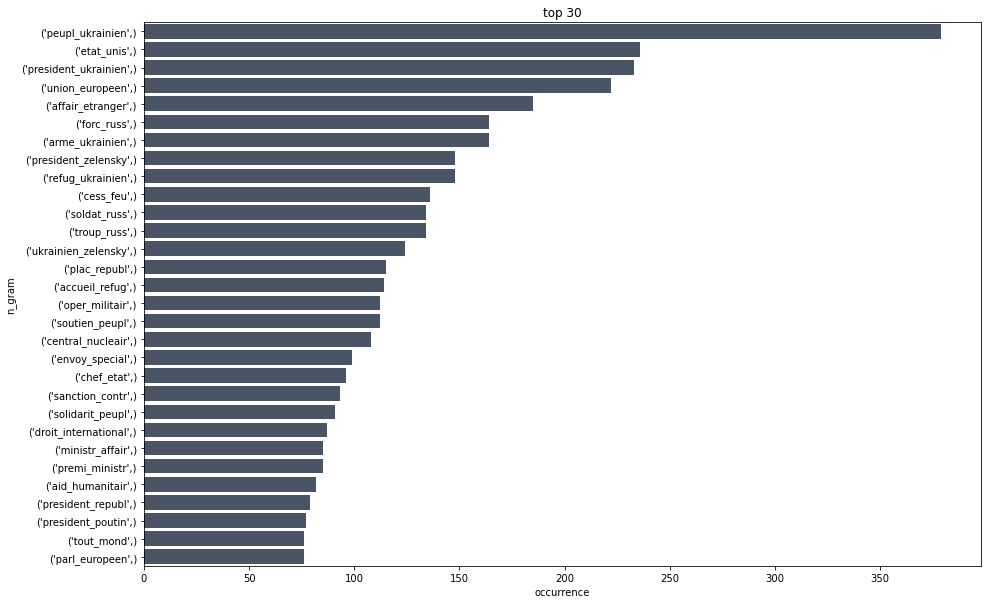

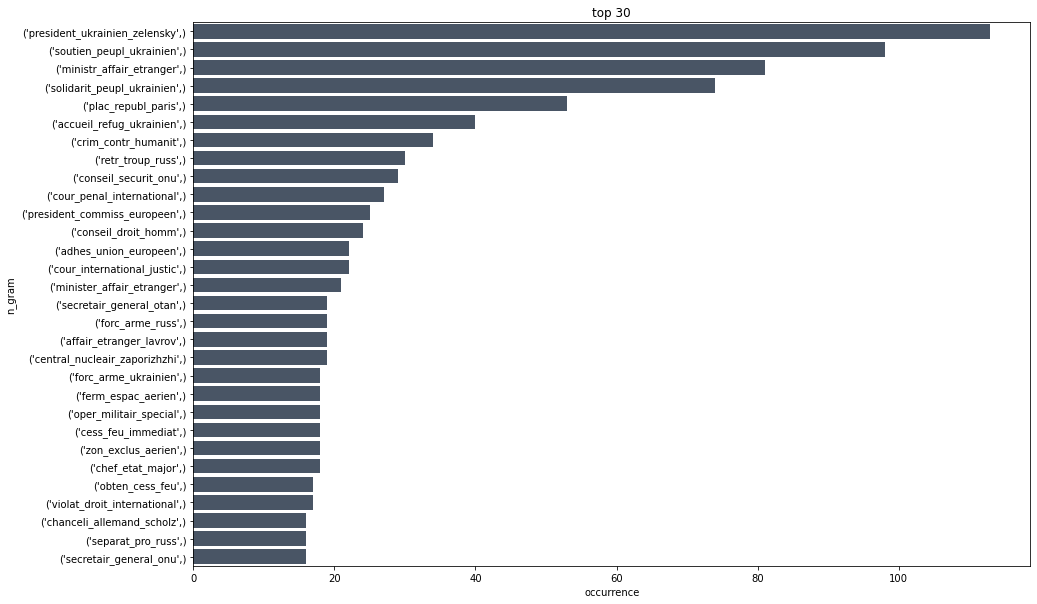

In [93]:
for col in new_cols_prepro:
    tokens = ' '.join(df_prepro[col]).split()
    ngram_top(tokens, n_gram = 1, n_top = 30)

## <span style="color:#191970">4. Vectorisation</span>

### <span style="color:#191970">4.1. CountVectorizer</span>

In [94]:
# Création du vectoriseur 
vectorizer = CountVectorizer(min_df=4) #limiter la taille du vocabulaire avec le paramètre min_df : prend les mots qui sortent au moins 4 fois

# Vectorisation de nos documents
X = vectorizer.fit_transform(df_prepro['text_clean'])
vect_array = X.toarray()
print(vect_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [95]:
print(f"Liste des features retenus : \n{vectorizer.get_feature_names_out()}")

Liste des features retenus : 
['abaisser' 'abandon' 'abandonne' ... 'zoom' 'zourabichvili' 'zozz']


In [96]:
##vocabulaire automatiquement constitué par Scikit-Learn (récupéré via vocabulary):
print (f"Taille: {len (vectorizer.vocabulary_)}")

Taille: 9320


In [97]:
df_cv = pd.DataFrame(data=vect_array,columns = vectorizer.get_feature_names_out())
print (df_cv)

       abaisser  abandon  abandonne  abandonnee  abandonner  abandonnes  \
0             0        0          0           0           0           0   
1             0        0          0           0           0           0   
2             0        0          0           0           0           0   
3             0        0          0           0           0           0   
4             0        0          0           0           0           0   
...         ...      ...        ...         ...         ...         ...   
19529         0        0          0           0           0           0   
19530         0        0          0           0           0           0   
19531         0        0          0           0           0           0   
19532         0        0          0           0           0           0   
19533         0        0          0           0           0           0   

       abarluet  abat  abattre  abattu  ...  zemmoureric  zemmourpresident  \
0             0     0

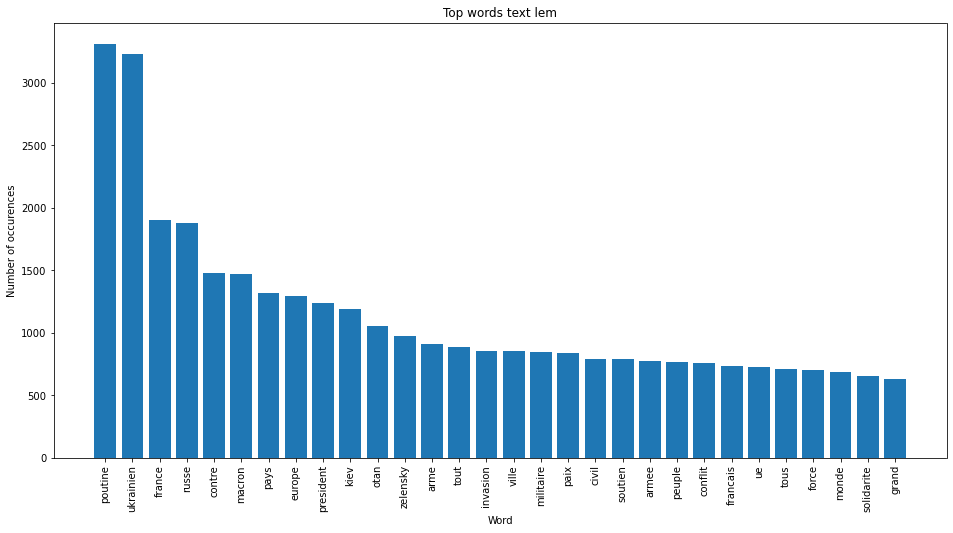

In [98]:
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=vectorizer,
                                     text_data=df_prepro["text_lemma"])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words text lem');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### <span style="color:#191970">4.2. tfidf</span>

In [99]:
print("Ce résultat représente les mots qui ont le meilleur score en utilisant la méthode tf-idf:")
get_tfidf_top_features(df_prepro["text_lemma"], n_top = 30)

Ce résultat représente les mots qui ont le meilleur score en utilisant la méthode tf-idf:


C:\Users\vnarv\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



array(['poutine', 'ukrainien', 'france', 'russe', 'macron', 'contre',
       'europe', 'pays', 'kiev', 'president', 'otan', 'zelensky',
       'invasion', 'arme', 'paix', 'tout', 'militaire', 'soutien',
       'ville', 'armee', 'conflit', 'civil', 'peuple', 'francais', 'ue',
       'solidarite', 'tous', 'monde', 'force', 'grand'], dtype='<U16')

### <span style="color:#191970">4.3. LDA</span>

In [11]:
pd.options.display.max_colwidth = 0

In [103]:
df_prepro.columns

Index(['datetime', 'tweet_id', 'text', 'username', 'like_count',
       'retweet_count', 'reply_count', 'quote_count', 'date', 'day', 'month',
       'time', 'hour', 'minute', 'hashtags', 'arrobas', 'text_clean',
       'language', 'text_stem', 'text_stem_bigram', 'text_stem_trigram',
       'text_lemma', 'text_lemma_bigram', 'text_lemma_trigram'],
      dtype='object')

===== Method : lemma =====
... Running bag of words
... Running search for best nb of topics
=== LDA model with 2 topics took : 0.97 minutes
Topic: 0 -> Words: 0.031*"ukrainien" + 0.016*"russe" + 0.013*"kiev" + 0.010*"armee" + 0.009*"civil" + 0.008*"crime" + 0.008*"mort" + 0.007*"soutien" + 0.007*"force" + 0.007*"donbass"
Topic: 1 -> Words: 0.014*"poutine" + 0.014*"macron" + 0.012*"france" + 0.010*"europe" + 0.010*"ue" + 0.009*"zelensky" + 0.008*"contre" + 0.007*"arme" + 0.007*"otan" + 0.007*"president"
=== Coherence Score: 0.27
=== LDA model with 3 topics took : 0.86 minutes
Topic: 0 -> Words: 0.038*"ukrainien" + 0.020*"russe" + 0.015*"kiev" + 0.012*"soutien" + 0.011*"civil" + 0.010*"crime" + 0.009*"mort" + 0.009*"amp" + 0.008*"force" + 0.008*"donbass"
Topic: 1 -> Words: 0.024*"france" + 0.017*"europe" + 0.016*"contre" + 0.015*"ue" + 0.013*"pays" + 0.012*"arme" + 0.012*"otan" + 0.010*"francais" + 0.009*"emmanuelmacron" + 0.008*"conflit"
Topic: 2 -> Words: 0.029*"poutine" + 0.028*"macr

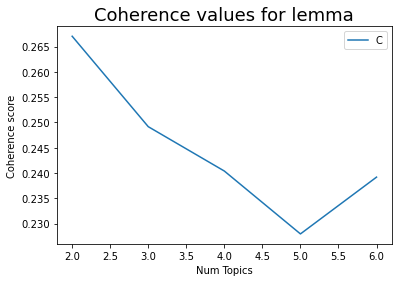

... Running lda with 2 topics
=== LDA model with 2 topics took : 0.98 minutes
Topic: 0 -> Words: 0.031*"ukrainien" + 0.016*"russe" + 0.013*"kiev" + 0.010*"armee" + 0.009*"civil" + 0.008*"crime" + 0.008*"mort" + 0.007*"soutien" + 0.007*"force" + 0.007*"donbass"
Topic: 1 -> Words: 0.014*"poutine" + 0.014*"macron" + 0.012*"france" + 0.010*"europe" + 0.010*"ue" + 0.009*"zelensky" + 0.008*"contre" + 0.007*"arme" + 0.007*"otan" + 0.007*"president"
=== Coherence Score: 0.27
... Running lda visualization
... Running lda visualization


C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



... Running dominant topics


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Format topics took 6.3 minutes
... Graph topics and keywords


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 13.435358341534933 minutes


index                                               text  \
tweet_id                                                                        
1488433061196812291      0  voilà l'info, malheureusement très peu reprise...   
1488447673883676672      1  #ukraine face à poutine ... macron hausse le t...   
1488493240475078658      2  crise en #ukraine : « emmanuel #macron et vlad...   
1488502446771081216      3  la #russie c'est l'équivalent du pib de l'ital...   
1488511509961527302      4  crise en #ukraine : voilà pourquoi il faut sor...   
...                    ...                                                ...   
1542967067611127813  19934  c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #...   
1542963887175335937  19935  👉 guerre un #ukraine : que faire pour aider le...   
1542971236459888641  19936  👉 guerre en #ukraine : le soft power des résea...   
1542969041161158656  19937  implacable. a gauche le peuple d’#ukraine qui ...   
1542981780092985344  19938  les urgences d'un hôpital ferment faute de soi...   

                            username  \
tweet_id                               
1488433061196812291        tcabarrus   
1488447673883676672          lapin47   
1488493240475078658  FaireEnsembleEM   
1488502446771081216  BrunoRetailleau   
1488511509961527302      f_philippot   
...                              ...   
1542967067611127813         Anna78__   
1542963887175335937              LCI   
1542971236459888641              LCI   
1542969041161158656      PJakubowicz   
1542981780092985344   LeDucDeLaToile   

                                                            text_lemma  \
tweet_id                                                                 
1488433061196812291  malheureusement tres peu reprise media entreti...   
1488447673883676672                         face poutine macron hausse   
1488493240475078658  crise macron poutine reparles hier dialogue ec...   
1488502446771081216  equivalent pib italie attention sanction pourr...   
1488511509961527302  crise pourquoi sortir piege atlantiste refuser...   
...                                                                ...   
1542967067611127813               magnifique tellement emouvant europe   
1542963887175335937  aider population vpecresse urgence hiver arriv...   
1542971236459888641  soft power reseaux vpecresse organiser chaos p...   
1542969041161158656  implacable gauche peuple compris drapeau europ...   
1542981780092985344  urgence hopital ferment faute soignant millier...   

                     document_no  dominant_topic  topic_perc_contrib  \
tweet_id                                                               
1488433061196812291            0               1              0.7994   
1488447673883676672            1               1              0.8412   
1488493240475078658            2               1              0.9276   
1488502446771081216            3               1              0.7694   
1488511509961527302            4               1              0.6348   
...                          ...             ...                 ...   
1542967067611127813        19529               1              0.5508   
1542963887175335937        19530               1              0.5637   
1542971236459888641        19531               1              0.5638   
1542969041161158656        19532               1              0.8981   
1542981780092985344        19533               1              0.5340   

                                                              keywords  \
tweet_id                                                                 
1488433061196812291  poutine, macron, france, europe, ue, zelensky,...   
1488447673883676672  poutine, macron, france, europe, ue, zelensky,...   
1488493240475078658  poutine, macron, france, europe, ue, zelensky,...   
1488502446771081216  poutine, macron, france, europe, ue, zelensky,...   
1488511509961527302  poutine, macron, france, europe, ue, zelensky,...   
...                         

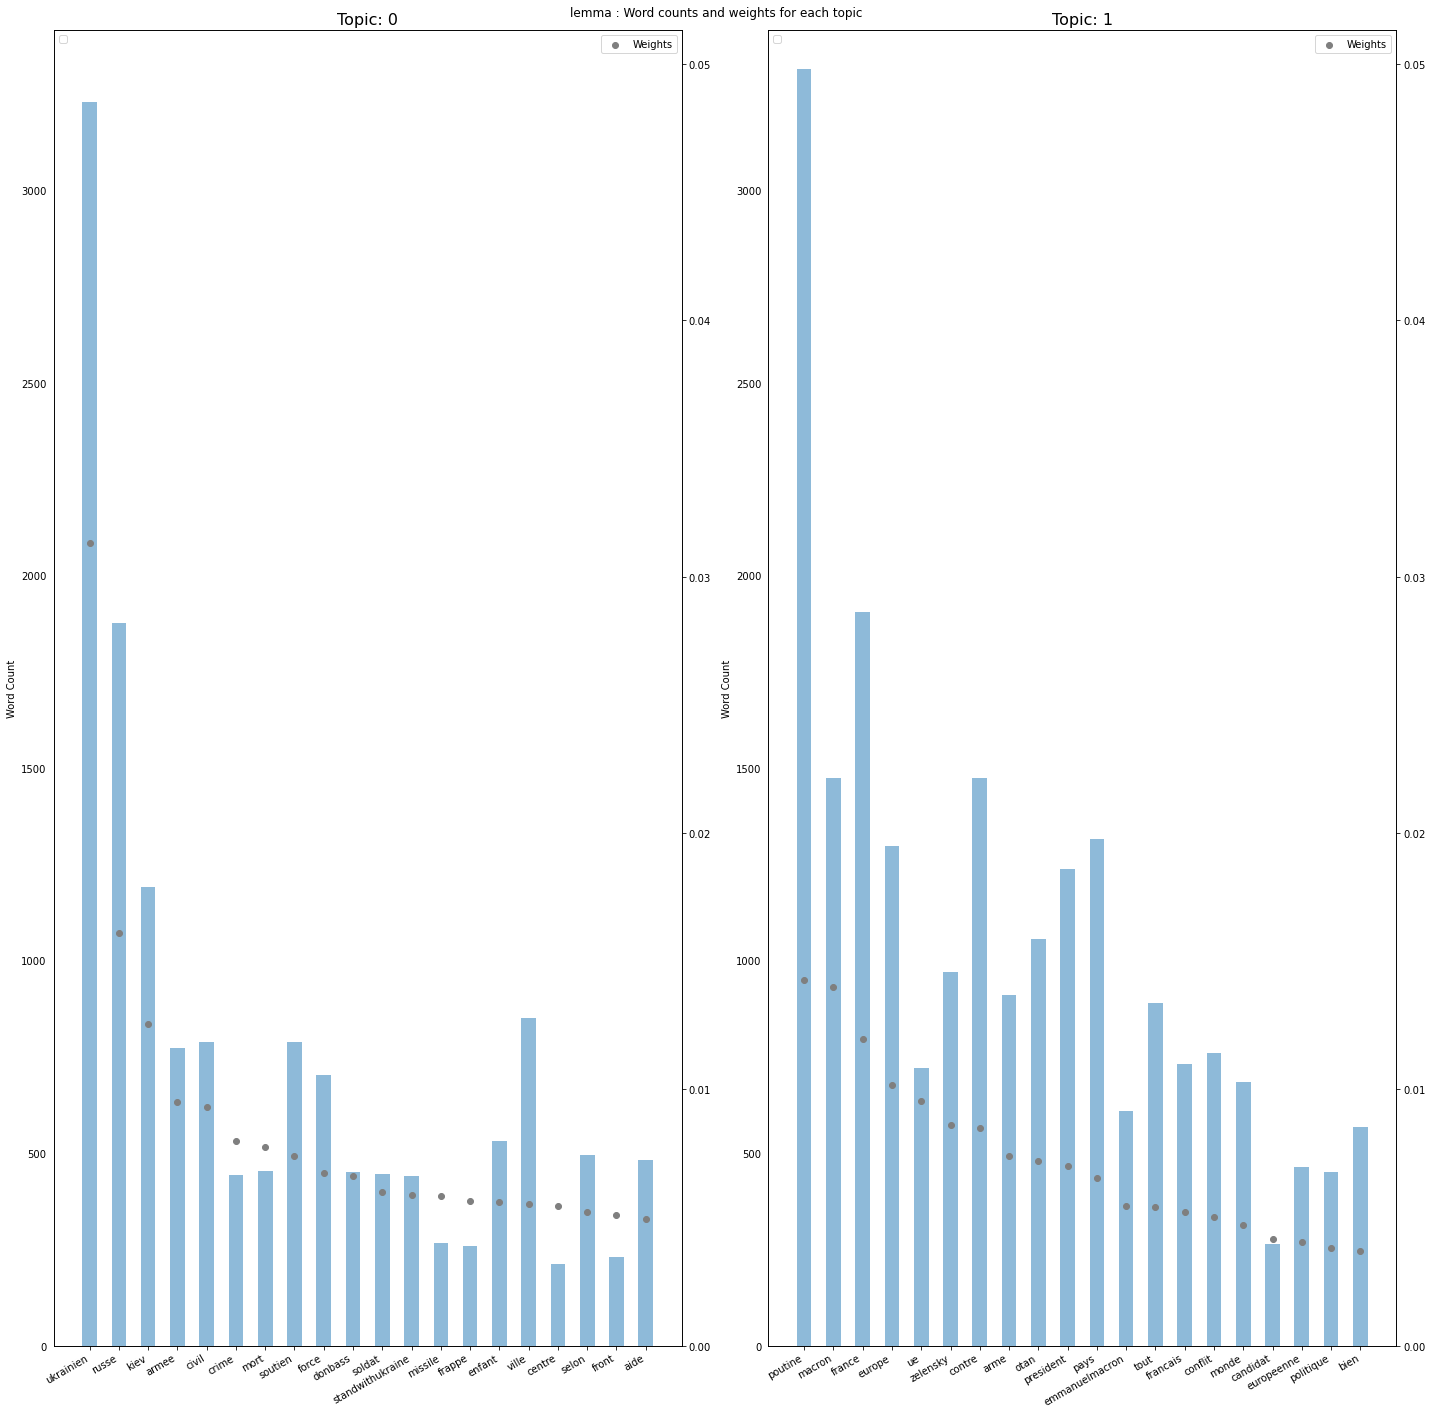

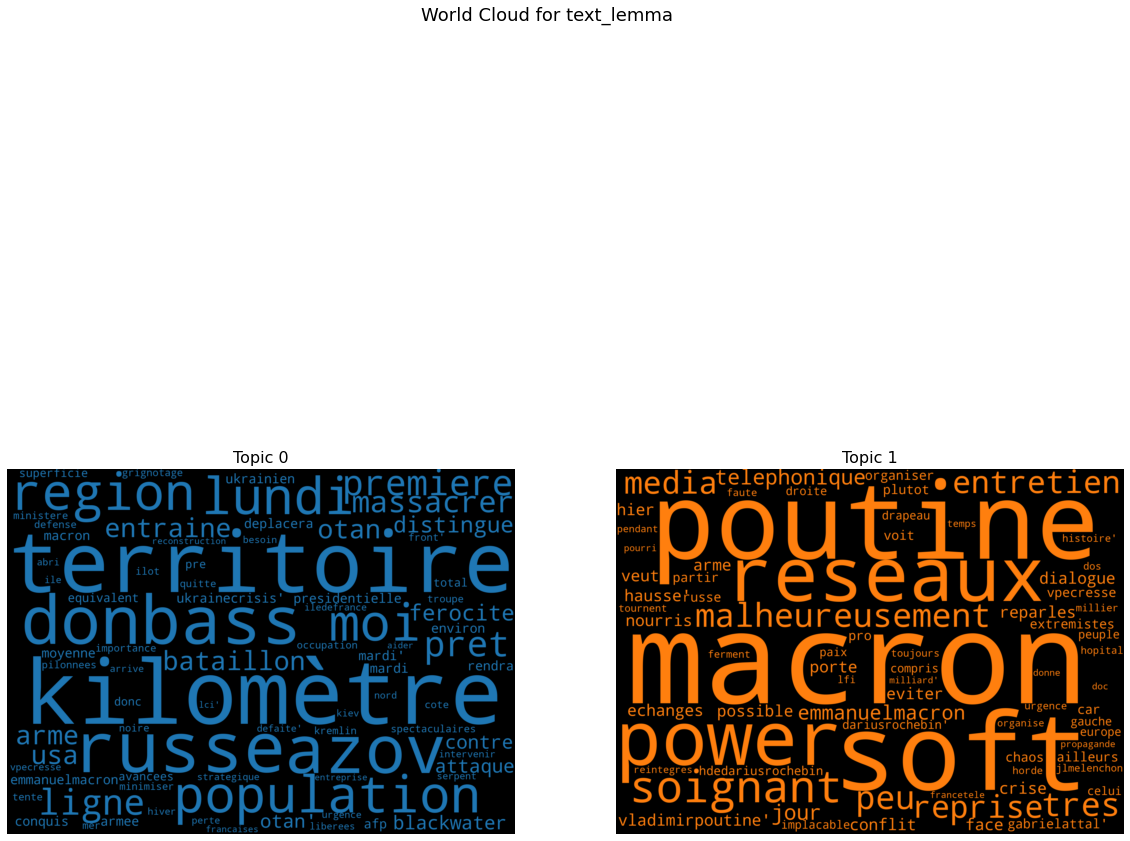

In [104]:
run_all(df_prepro.copy(deep=True), "text_lemma", "lemma", True)

In [ ]:
df_lemma_2topics = pd.read_csv(path + "output/min_retweet_3/dominant_topics_lemma_2topics.csv", sep=";")
filter_columns = ["text", "username", "dominant_topic",
                 "topic_perc_contrib", "keywords"]

df_lemma_2topics = df_lemma_2topics[filter_columns]
for i in df_lemma_2topics["dominant_topic"].unique():
    display(df_lemma_2topics[
        df_lemma_2topics["dominant_topic"]==i
    ].sort_values(by=["dominant_topic",
                      "topic_perc_contrib"], ascending=[True, False]).head(20))

===== Method : lemma =====
... Running bag of words
... Running lda with 3 topics
=== LDA model with 3 topics took : 0.9 minutes
Topic: 0 -> Words: 0.038*"ukrainien" + 0.020*"russe" + 0.015*"kiev" + 0.012*"soutien" + 0.011*"civil" + 0.010*"crime" + 0.009*"mort" + 0.009*"amp" + 0.008*"force" + 0.008*"donbass"
Topic: 1 -> Words: 0.024*"france" + 0.017*"europe" + 0.016*"contre" + 0.015*"ue" + 0.013*"pays" + 0.012*"arme" + 0.012*"otan" + 0.010*"francais" + 0.009*"emmanuelmacron" + 0.008*"conflit"
Topic: 2 -> Words: 0.029*"poutine" + 0.028*"macron" + 0.017*"zelensky" + 0.014*"president" + 0.012*"armee" + 0.010*"an" + 0.010*"tout" + 0.009*"monde" + 0.008*"candidat" + 0.008*"grand"
=== Coherence Score: 0.25
... Running lda visualization
... Running lda visualization


C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



... Running dominant topics


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Format topics took 6.0 minutes


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph topics and keywords


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 7.511346121629079 minutes


index                                               text  \
tweet_id                                                                        
1488433061196812291      0  voilà l'info, malheureusement très peu reprise...   
1488447673883676672      1  #ukraine face à poutine ... macron hausse le t...   
1488493240475078658      2  crise en #ukraine : « emmanuel #macron et vlad...   
1488502446771081216      3  la #russie c'est l'équivalent du pib de l'ital...   
1488511509961527302      4  crise en #ukraine : voilà pourquoi il faut sor...   
...                    ...                                                ...   
1542967067611127813  19934  c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #...   
1542963887175335937  19935  👉 guerre un #ukraine : que faire pour aider le...   
1542971236459888641  19936  👉 guerre en #ukraine : le soft power des résea...   
1542969041161158656  19937  implacable. a gauche le peuple d’#ukraine qui ...   
1542981780092985344  19938  les urgences d'un hôpital ferment faute de soi...   

                            username  \
tweet_id                               
1488433061196812291        tcabarrus   
1488447673883676672          lapin47   
1488493240475078658  FaireEnsembleEM   
1488502446771081216  BrunoRetailleau   
1488511509961527302      f_philippot   
...                              ...   
1542967067611127813         Anna78__   
1542963887175335937              LCI   
1542971236459888641              LCI   
1542969041161158656      PJakubowicz   
1542981780092985344   LeDucDeLaToile   

                                                            text_lemma  \
tweet_id                                                                 
1488433061196812291  malheureusement tres peu reprise media entreti...   
1488447673883676672                         face poutine macron hausse   
1488493240475078658  crise macron poutine reparles hier dialogue ec...   
1488502446771081216  equivalent pib italie attention sanction pourr...   
1488511509961527302  crise pourquoi sortir piege atlantiste refuser...   
...                                                                ...   
1542967067611127813               magnifique tellement emouvant europe   
1542963887175335937  aider population vpecresse urgence hiver arriv...   
1542971236459888641  soft power reseaux vpecresse organiser chaos p...   
1542969041161158656  implacable gauche peuple compris drapeau europ...   
1542981780092985344  urgence hopital ferment faute soignant millier...   

                     document_no  dominant_topic  topic_perc_contrib  \
tweet_id                                                               
1488433061196812291            0               2              0.4774   
1488447673883676672            1               1              0.4128   
1488493240475078658            2               1              0.6192   
1488502446771081216            3               1              0.5702   
1488511509961527302            4               1              0.5226   
...                          ...             ...                 ...   
1542967067611127813        19529               1              0.4146   
1542963887175335937        19530               2              0.3891   
1542971236459888641        19531               0              0.4193   
1542969041161158656        19532               1              0.5497   
1542981780092985344        19533               0              0.3763   

                                                              keywords  \
tweet_id                                                                 
1488433061196812291  poutine, macron, zelensky, president, armee, a...   
1488447673883676672  france, europe, contre, ue, pays, arme, otan, ...   
1488493240475078658  france, europe, contre, ue, pays, arme, otan, ...   
1488502446771081216  france, europe, contre, ue, pays, arme, otan, ...   
1488511509961527302  france, europe, contre, ue, pays, arme, otan, ...   
...                         

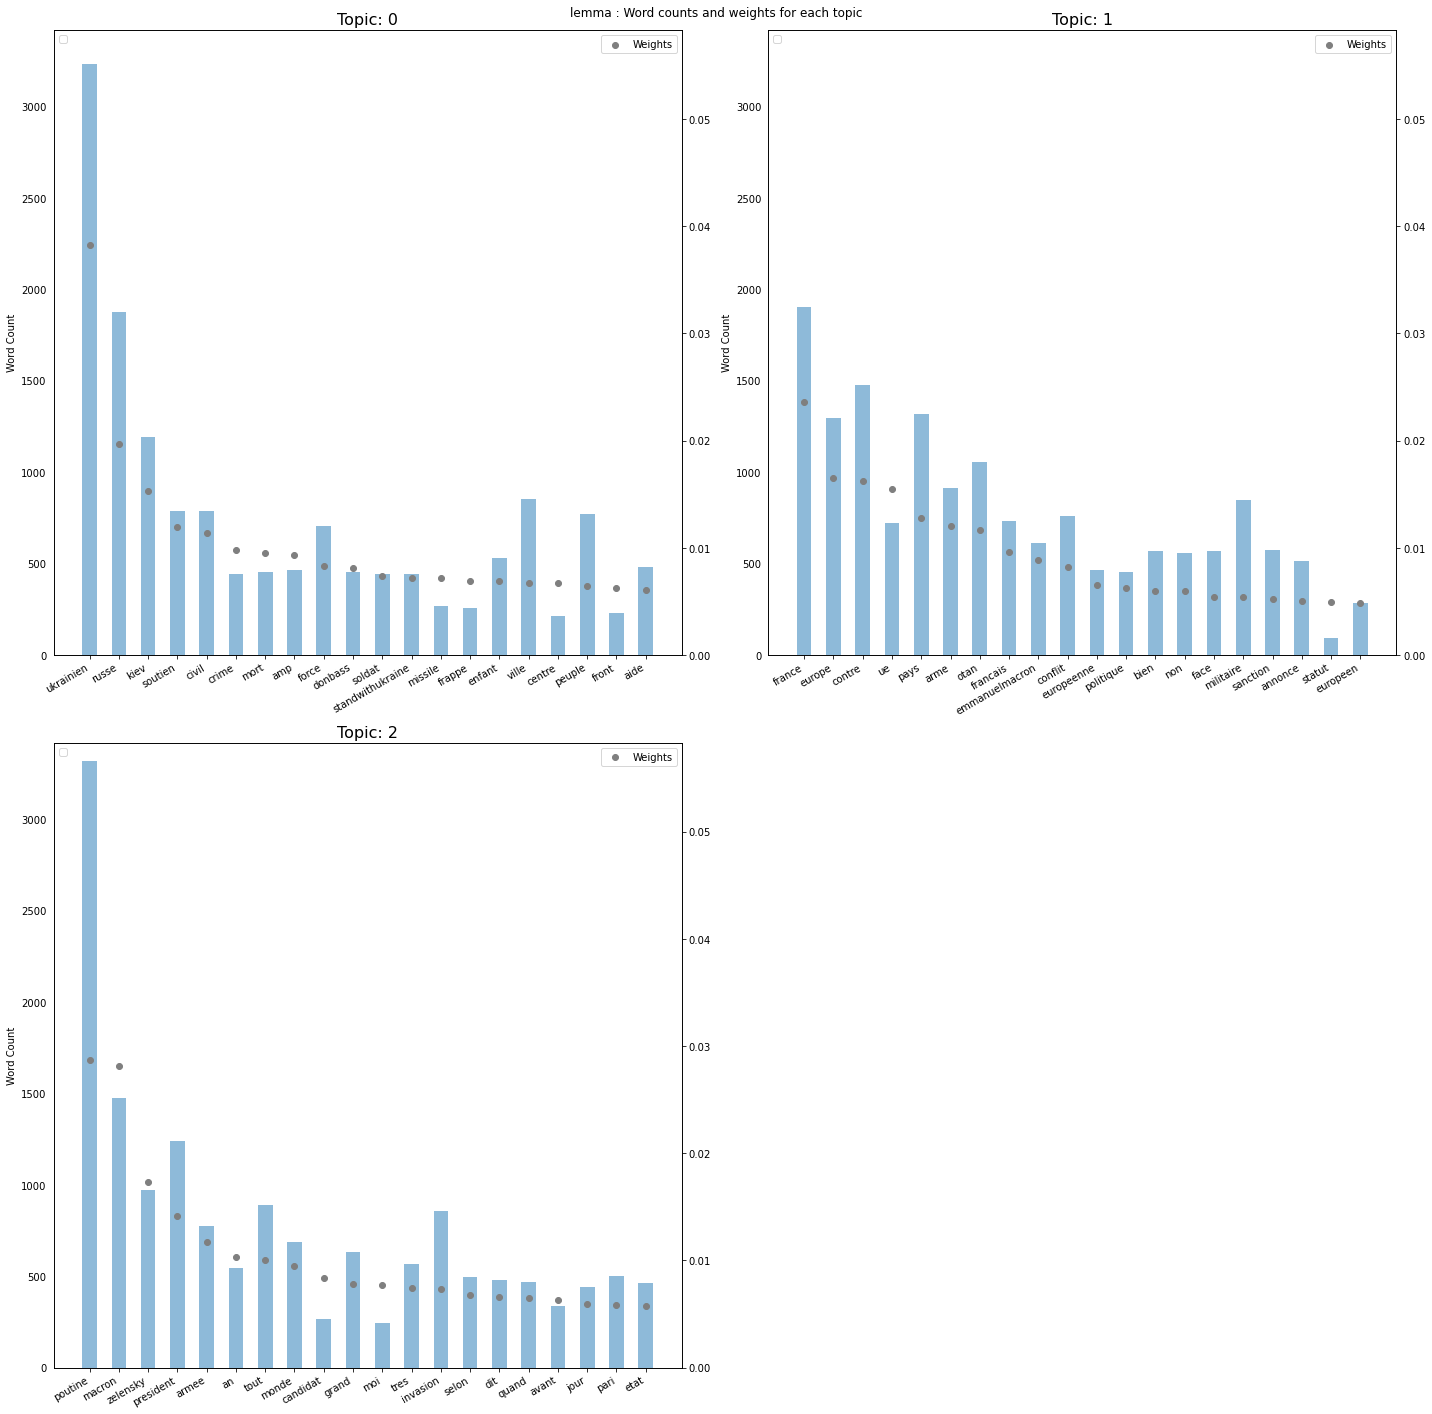

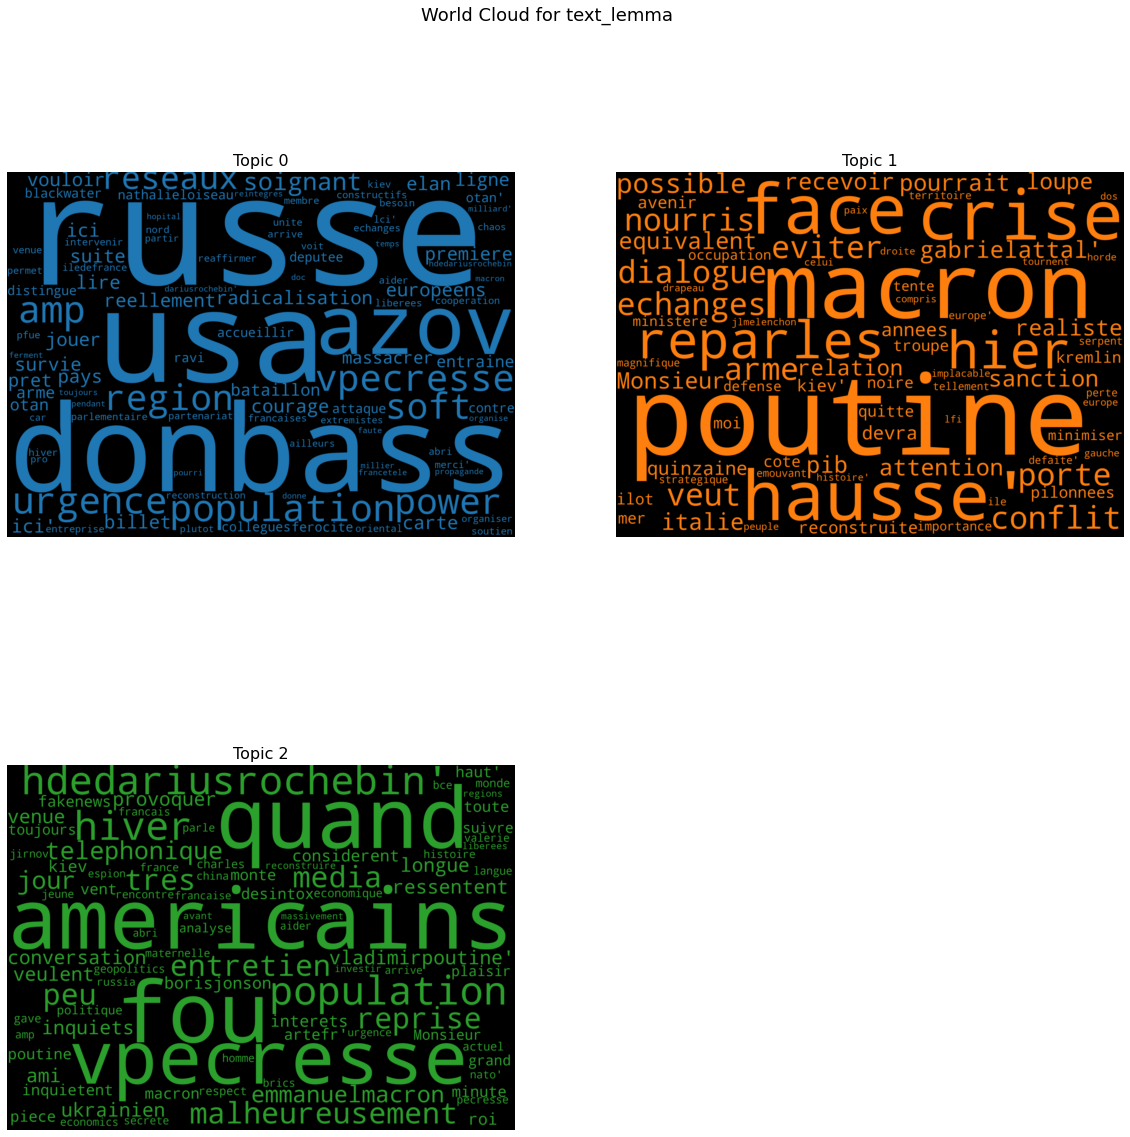

In [106]:
run_all(df_prepro.copy(deep=True), "text_lemma", "lemma", False, 3)

In [20]:
df_lemma_3topics = pd.read_csv(path + "output/min_retweet_3/dominant_topics_lemma_3topics.csv", sep=";")
filter_columns = ["text", "username", "dominant_topic",
                 "topic_perc_contrib", "keywords"]

df_lemma_3topics = df_lemma_3topics[filter_columns]
for i in df_lemma_3topics["dominant_topic"].unique():
    display(df_lemma_3topics[
        df_lemma_3topics["dominant_topic"]==i
    ].sort_values(by=["dominant_topic",
                      "topic_perc_contrib"], ascending=[True, False]).head(20))

text  \
15486  #ukraine l’allemagne devrait prendre un peu de recul, d’autant plus que l’activisme de #ursulavonderleyen ne rend pas facile le règlement de ce conflit par voie diplomatique qui permettrait une paix durable entre les belligérants de ce conflit, sauf à servir d’autres intérêts… https://t.co/2x1ne9jgwu            
142    @europe1 en 2008 au sommet de l’#otan à #budapest #bush voulait que l’#ukraine rentre dans l’#otan ! #sarkozy à dit non ! les américains ont stoppé ! #macron discute 5h avec #poutine ! il suffirait de dire non à #biden et le problème serait réglé ! quelle impuissance européenne!                                  
13851  tres important (et 1 peu passé à l'as)\r\nle président #biden a choisi, pour rassurer ses alliés otan en pleine guerre d'#ukraine, de renier son engagement majeur de campagne sur l'arme #nucléaire, dit du "sole purpose" (seul but) vu comme 1 moindre garantie https://t.co/uct9340yka                               
1464   sauf qu'il n'est pas question d'intégrer l'ukraine à l'otan. #poutine exige que l'#ukraine renonce définitivement à la possibilité d'intégrer un jour l'#otan cette exigence est inacceptable car elle remet en cause la souveraineté d'un état. vous prenez les français pour des cons https://t.co/i5qsqpv71n          
14932  je comprends pas  #macron le principale responsable avec les #usa l’#ue et #poutine de cette guerre parce qu’il n’a pas fait appliquer les accords de #minsk et laisser filer l’idée que l’#ukraine pouvait rentrer dans l’#otan se mette en mode guerrier avec ces sanctions brutales !                                 
5730   #poutine est méchant\r\nla guerre c'est pas gentil\r\nl'#otan c'est bien\r\nla russie c'est mal\r\nl'#ukraine c'est l'europe\r\n!'ue c'est gentil \r\nl' #ukraine c'est l'ue\r\nl'#otan et l'#ue c'est bien\r\nla paix c'est gentil\r\n#poutine est méchant\r\nla guerre c'est bien contre les méchants.                 
15975  #cavous @emmanuelmacron n'exclut pas de reparler à #poutine, il est extrêmement courageux notre président, très lucide, très prudent, et puis inutile de lui demander s'il est au courant de quoi que ce soit, il sait tout, c'est si grave l'#ukraine, grande confiance #macron2022                                     
16825  regardez comment #ursula\r\nprésidente de la commission #ue\r\nest soumise aux #usa !\r\n\r\nregardez #ursulavonderleyen \r\nlaisser #biden dire qu'il est prêt\r\nà faire de sacrifice de couper \r\nle #gaz russe en #europe !\r\n\r\n#russie #ukraine #petrole #energie #gaz #pfizer\r\n\r\nhttps://t.co/stakuwtvav   
497    marine #lepen n'arrive pas, dit-elle, à croire qu'#emmanuelmacron "soit pour quelque chose" dans la #desescalade de la crise en #ukraine. et elle commence à flotter grave quand elle parle du commandement intégré de l'#otan. c'est pas son truc. bref, elle n'y connaît rien😡 (#lci)                                  
482    l'#ue devra opposer une réponse forte en cas d'agression contre l'#ukraine. mais à l'évidence l'adhésion de ce pays à l'#otan serait un facteur de guerre. seuls la négociation et le respect des accords de minsk nous sortiront de l'impasse actuelle.\r\n👉 mon intervention en plénière https://t.co/ywvav3merc       
1322   en l’état actuel, je doute que la france puisse jouer un rôle dans le règlement du conflit en #ukraine. ni la france ni l’ue qui marche en ordre dispersé. la france doit retrouver la voix diplomatique qui a été la sienne #jeanlassalle2022 @rfi https://t.co/jpckm8cgev                                              
1522   #poutine remarque que les usa ont déclenché une guerre impérialiste en irak sur des accusations hypocrites d’armes chimiques inventées.\r\n\r\nle hoax des armes chimiques démontre l’hypocrisie de l’otan qui justifie toujours ses guerres impérialistes derrière des mensonges \r\n\r\n#ukraine                       
11376  si les négociations menées entre #poutine, #zelensky,le 1er ministre  israelien, dont est exclu le président français aboutissent sur

text  \
9520   sur le front nord : \r\n\r\n7. kiev : l’encerclement de la ville se poursuit. les combats continuent pour le contrôle de la zone nord-ouest de l’oblast de kiev. la ligne de contact se situe désormais à une vingtaine de kilomètres au nord de kiev. \r\n\r\n#ukraine                                                            
19440  #ukraine 30/06 depuis plusieurs jours, l’armée rus lance ses missiles sur les villes.\r\nici le 28/06 à mykolaiv ce kh-22 (1 t de charge explosive) percute un immeuble d’habitation où dormaient des civils.\r\nparmi 3 morts, ève, une jeune fille de 6 ans tuée dans son lit. https://t.co/mhlotlmlqi                           
10318  #ukraine\r\nsamedi un convoi humanitaire quittera #toulouse pour #montpellier en direction de la pologne, afin d’acheminer les dons recueillis ici aux ong qui aident sur place les réfugiés. \r\nje salue le grand élan de solidarité des citoyens, associations, collectivités, entreprises. https://t.co/uwce7hth0m             
11332  les russes ont abattu des civils lors d'une évacuation du village #peremoha. il n'y avait que des femmes et des enfants. pour l'instant, les autorités confirment que sept personnes ont été tuées, dont un enfant.  nombre total de victimes inconnu. #ukraine                                                                    
9523   sur le front est : zone de progression des forces russes\r\n \r\n1. donbass : les forces séparatistes ont réussi une percée dans le nord du donbass.\r\n\r\n2. kharkiv : les bombardements montent en intensité. l’encerclement de la ville est en cours par les forces russes. \r\n\r\n#ukraine                                   
7213   🇺🇦 à qui faire un #don pour l'#ukraine ?\r\n\r\nplus de 20 initiatives d'#associations ➡ https://t.co/lh1me2drso\r\n◾ aide d’urgence auprès des populations\r\n◾ accès aux soins médicaux\r\n◾ aide aux 7,5 millions d’enfants sur place\r\n◾ l’accueil des réfugiés ukrainiens\r\n\r\n#standwithukraine https://t.co/k6fxmjtx7i   
4394   ⚡️ video choc / #ukraine : une vidéo mise en ligne aujourd'hui montre de violents combats dans les rues de #kiev, entre des militaires russes et des forces de sécurités ukrainiennes. #kyiv #russiaukrainewar  #украина #ukrainerussia #worldwar3 #ukrainerussia #ukraineunderattack https://t.co/bycyiaseun                      
13149  en #ukraine, les bombardements se sont poursuivis à kiev, lundi. un raid a notamment dévasté un centre commercial, faisant au moins huit morts et laissant une mer de décombres. \r\n\r\nle reportage de notre envoyée spéciale @bedardme au #tj22h https://t.co/bcxuojbcx2                                                        
9529   terrible photo, qui me hante depuis que je l’ai vue (attention, elle est violente). a irpin, près du pont détruit, une famille tentait de fuir kiev. un tir de mortier a tué la mère, l’adolescent et la jeune fille de 8 ans. le père a été gravement blessé. #ukraine @nytimes https://t.co/du70p9ecbb                           
15979  la #russie a frappé l'#ukraine lundi avec le plus grand nombre d'attaques de missiles depuis des semaines. #moscou affirme avoir touché des centaines de cibles en préparation de l'offensive dans l'est. 5 missiles sur #lviv dans l'ouest, faisant au moins 7 morts.. https://t.co/0hnzugltvs                                    
17982  ⚠️#ukraine - front sud 1/2 :\r\n▶️attaque terroriste🇺🇦 à la voiture piégée à melitopol ce matin : 3 civils blessés\r\n▶️la nièce du gouverneur🇷🇺 fait partie des blessés ▶️l'explosion s'est produite lors de la distribution d'aide humanitaire à proximité\r\n.../... https://t.co/eyb8icjv0y                                    
10074  ℹ️sur le front nord :\r\n\r\n#soumy :\r\n• okhtyrka serait encerclée par les forces russes (75km\r\nau sud de soumy).\r\n\r\n#chernihiv :\r\n• l’armée ukrainienne est prise en tenaille dans la\r\nrégion de nizhnyn (50km au sud-est de tchernihiv).\r\n\r\n#ukraine [5/6] https://t.co/oh0jn6bhg5                               
9274   merci à @iapo

===== Method : lemma_bigram =====
... Running bag of words
... Running search for best nb of topics
=== LDA model with 2 topics took : 1.4 minutes
Topic: 0 -> Words: 0.018*"accord_minsk" + 0.017*"statut_candidat" + 0.016*"peuple_ukrainien" + 0.013*"centre_commercial" + 0.011*"leclerc_imhoff" + 0.009*"sanction_contre" + 0.009*"president_emmanuelmacron" + 0.009*"chef_etat" + 0.008*"soldat_russe" + 0.007*"mer_noire"
Topic: 1 -> Words: 0.029*"union_europeenne" + 0.017*"statut_candidat" + 0.014*"armee_ukrainien" + 0.014*"affaire_etrangeres" + 0.013*"centre_commercial" + 0.013*"etats_uni" + 0.013*"president_zelensky" + 0.013*"force_russe" + 0.012*"leclerc_imhoff" + 0.008*"pro_poutine"
=== Coherence Score: 0.74
=== LDA model with 3 topics took : 1.4 minutes
Topic: 0 -> Words: 0.024*"peuple_ukrainien" + 0.020*"armee_ukrainien" + 0.016*"centre_commercial" + 0.013*"chef_etat" + 0.012*"quelques_jour" + 0.012*"mer_noire" + 0.012*"soldat_russe" + 0.012*"force_ru" + 0.012*"pro_poutine" + 0.011*"droi

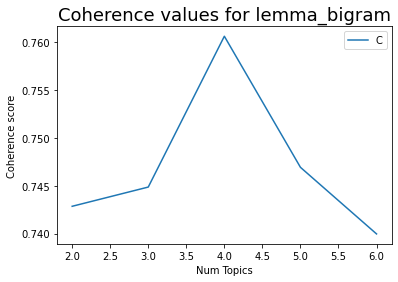

... Running lda with 4 topics
=== LDA model with 4 topics took : 1.4 minutes
Topic: 0 -> Words: 0.027*"armee_ukrainien" + 0.018*"chef_etat" + 0.017*"centre_commercial" + 0.017*"quelques_jour" + 0.016*"soldat_russe" + 0.016*"force_ru" + 0.016*"frappe_missile" + 0.015*"soldat_ukrainien" + 0.015*"parlement_europeen" + 0.015*"ile_serpent"
Topic: 1 -> Words: 0.030*"affaire_etrangeres" + 0.023*"conseil_europeen" + 0.019*"securite_alimentaire" + 0.018*"ministre_affaire" + 0.017*"regime_kiev" + 0.017*"livraison_arme" + 0.015*"frappe_russe" + 0.015*"alimentaire_mondiale" + 0.013*"tout_monde" + 0.013*"leclerc_imhoff"
Topic: 2 -> Words: 0.065*"statut_candidat" + 0.057*"union_europeenne" + 0.024*"president_zelensky" + 0.024*"etats_uni" + 0.024*"force_russe" + 0.019*"president_emmanuelmacron" + 0.015*"candidat_ue" + 0.014*"president_ukrainien" + 0.014*"crime_contre" + 0.013*"macron_ue"
Topic: 3 -> Words: 0.036*"accord_minsk" + 0.031*"peuple_ukrainien" + 0.018*"sanction_contre" + 0.017*"centre_comme

C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


... Running dominant topics


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


Format topics took 1.2e+01 minutes
... Graph topics and keywords


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called w

... Graph word cloud for each topic

 Total running time: 21.911591704686483 minutes


index  \
tweet_id                     
1488433061196812291  0       
1488447673883676672  1       
1488493240475078658  2       
1488502446771081216  3       
1488511509961527302  4       
...                 ..       
1542967067611127813  19934   
1542963887175335937  19935   
1542971236459888641  19936   
1542969041161158656  19937   
1542981780092985344  19938   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc                                                                                                                                
1488447673883676672  #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv                                                                                                                                                                                                                                                
1488493240475078658  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i                                                                           
1488502446771081216  la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl                            
1488511509961527302  crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk                                                                                                                                                       
...                                                                                                                                                                                                                                                                                                             ...                            
1542967067611127813  c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot                                                                                                                                                                                                                                     
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641  👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 #le20hde

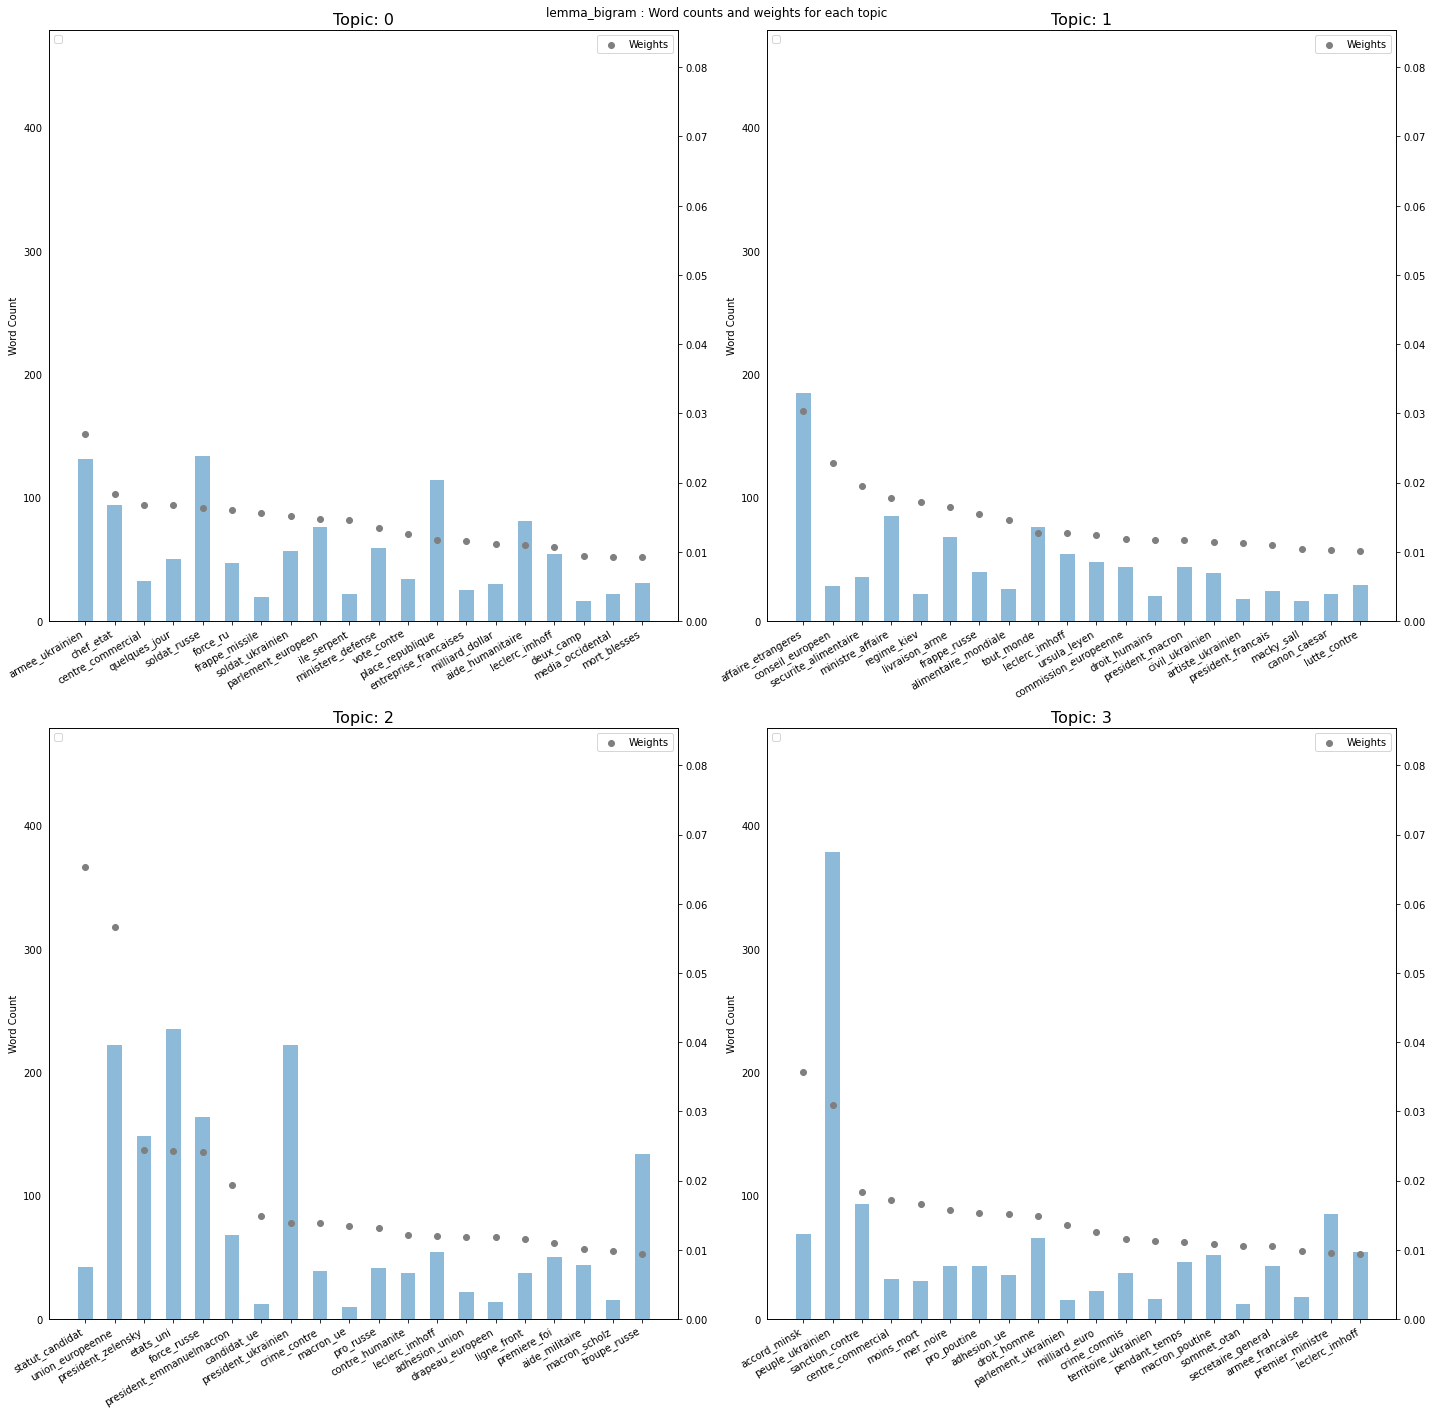

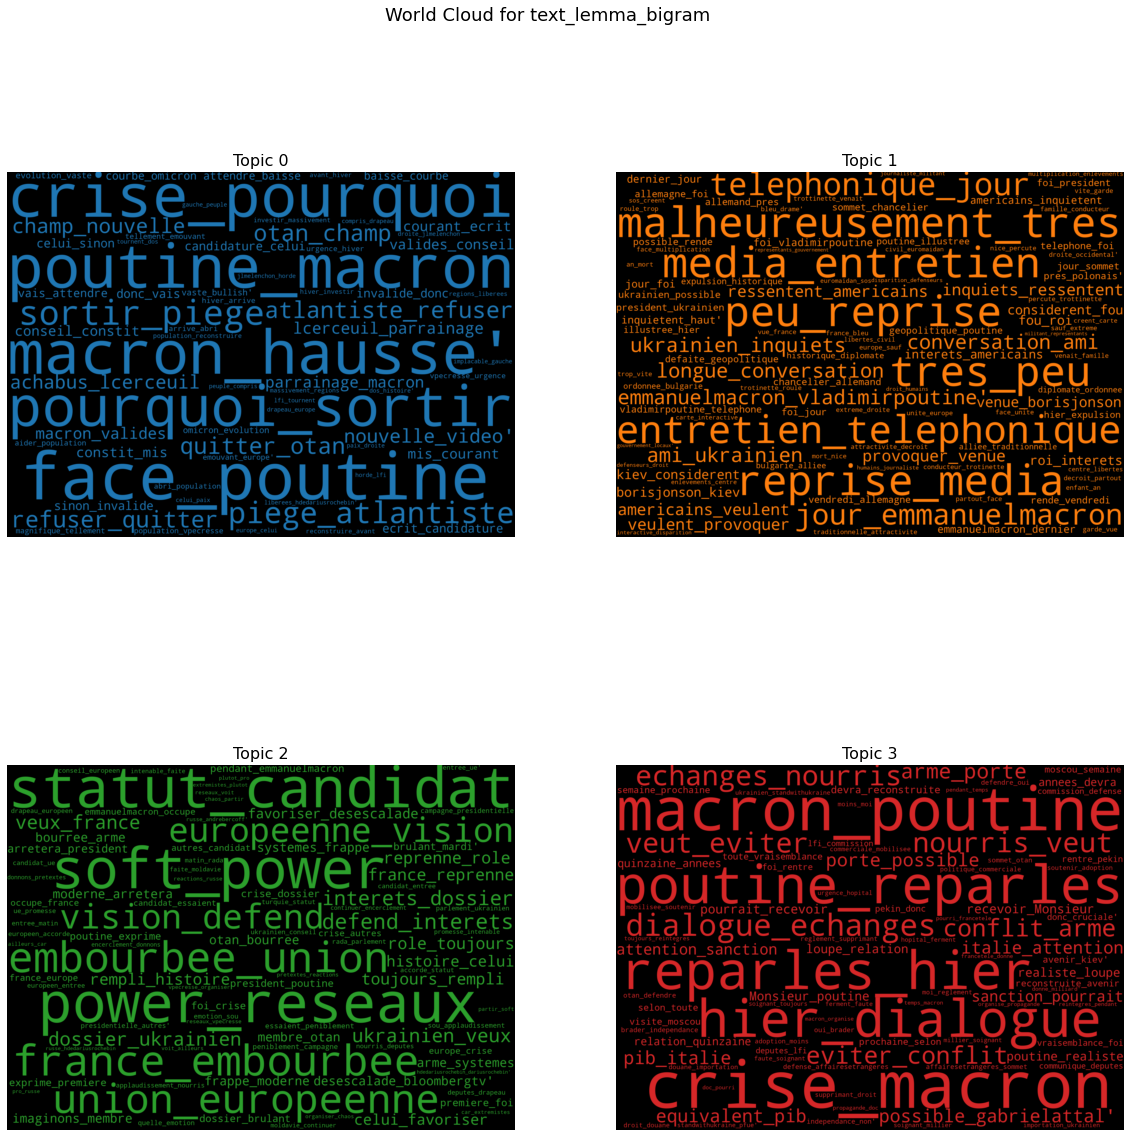

In [19]:
run_all(df_prepro.copy(deep=True), "text_lemma_bigram", "lemma_bigram", True)

In [ ]:
df_lemma_bigram_4topics = pd.read_csv(path + "output/min_retweet_3/dominant_topics_lemma_bigram_4topics.csv", sep=";")
filter_columns = ["text", "username", "dominant_topic",
                 "topic_perc_contrib", "keywords"]

df_lemma_bigram_4topics = df_lemma_bigram_4topics[filter_columns]
for i in df_lemma_bigram_4topics["dominant_topic"].unique():
    display(df_lemma_bigram_4topics[
        df_lemma_bigram_4topics["dominant_topic"]==i
    ].sort_values(by=["dominant_topic",
                      "topic_perc_contrib"], ascending=[True, False]).head(20))

===== Method : lemma_bigram =====
... Running bag of words
... Running lda with 2 topics
=== LDA model with 2 topics took : 0.77 minutes
Topic: 0 -> Words: 0.018*"accord_minsk" + 0.017*"statut_candidat" + 0.016*"peuple_ukrainien" + 0.013*"centre_commercial" + 0.011*"leclerc_imhoff" + 0.009*"sanction_contre" + 0.009*"president_emmanuelmacron" + 0.009*"chef_etat" + 0.008*"soldat_russe" + 0.007*"mer_noire"
Topic: 1 -> Words: 0.029*"union_europeenne" + 0.017*"statut_candidat" + 0.014*"armee_ukrainien" + 0.014*"affaire_etrangeres" + 0.013*"centre_commercial" + 0.013*"etats_uni" + 0.013*"president_zelensky" + 0.013*"force_russe" + 0.012*"leclerc_imhoff" + 0.008*"pro_poutine"
=== Coherence Score: 0.74
... Running lda visualization
... Running lda visualization


C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


... Running dominant topics


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


Format topics took 8.4 minutes
... Graph topics and keywords


C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\model\tools_modelling.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 9.897187900543212 minutes


index  \
tweet_id                     
1488433061196812291  0       
1488447673883676672  1       
1488493240475078658  2       
1488502446771081216  3       
1488511509961527302  4       
...                 ..       
1542967067611127813  19934   
1542963887175335937  19935   
1542971236459888641  19936   
1542969041161158656  19937   
1542981780092985344  19938   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291  voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc                                                                                                                                
1488447673883676672  #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv                                                                                                                                                                                                                                                
1488493240475078658  crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i                                                                           
1488502446771081216  la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl                            
1488511509961527302  crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk                                                                                                                                                       
...                                                                                                                                                                                                                                                                                                             ...                            
1542967067611127813  c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot                                                                                                                                                                                                                                     
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641  👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 #le20hde

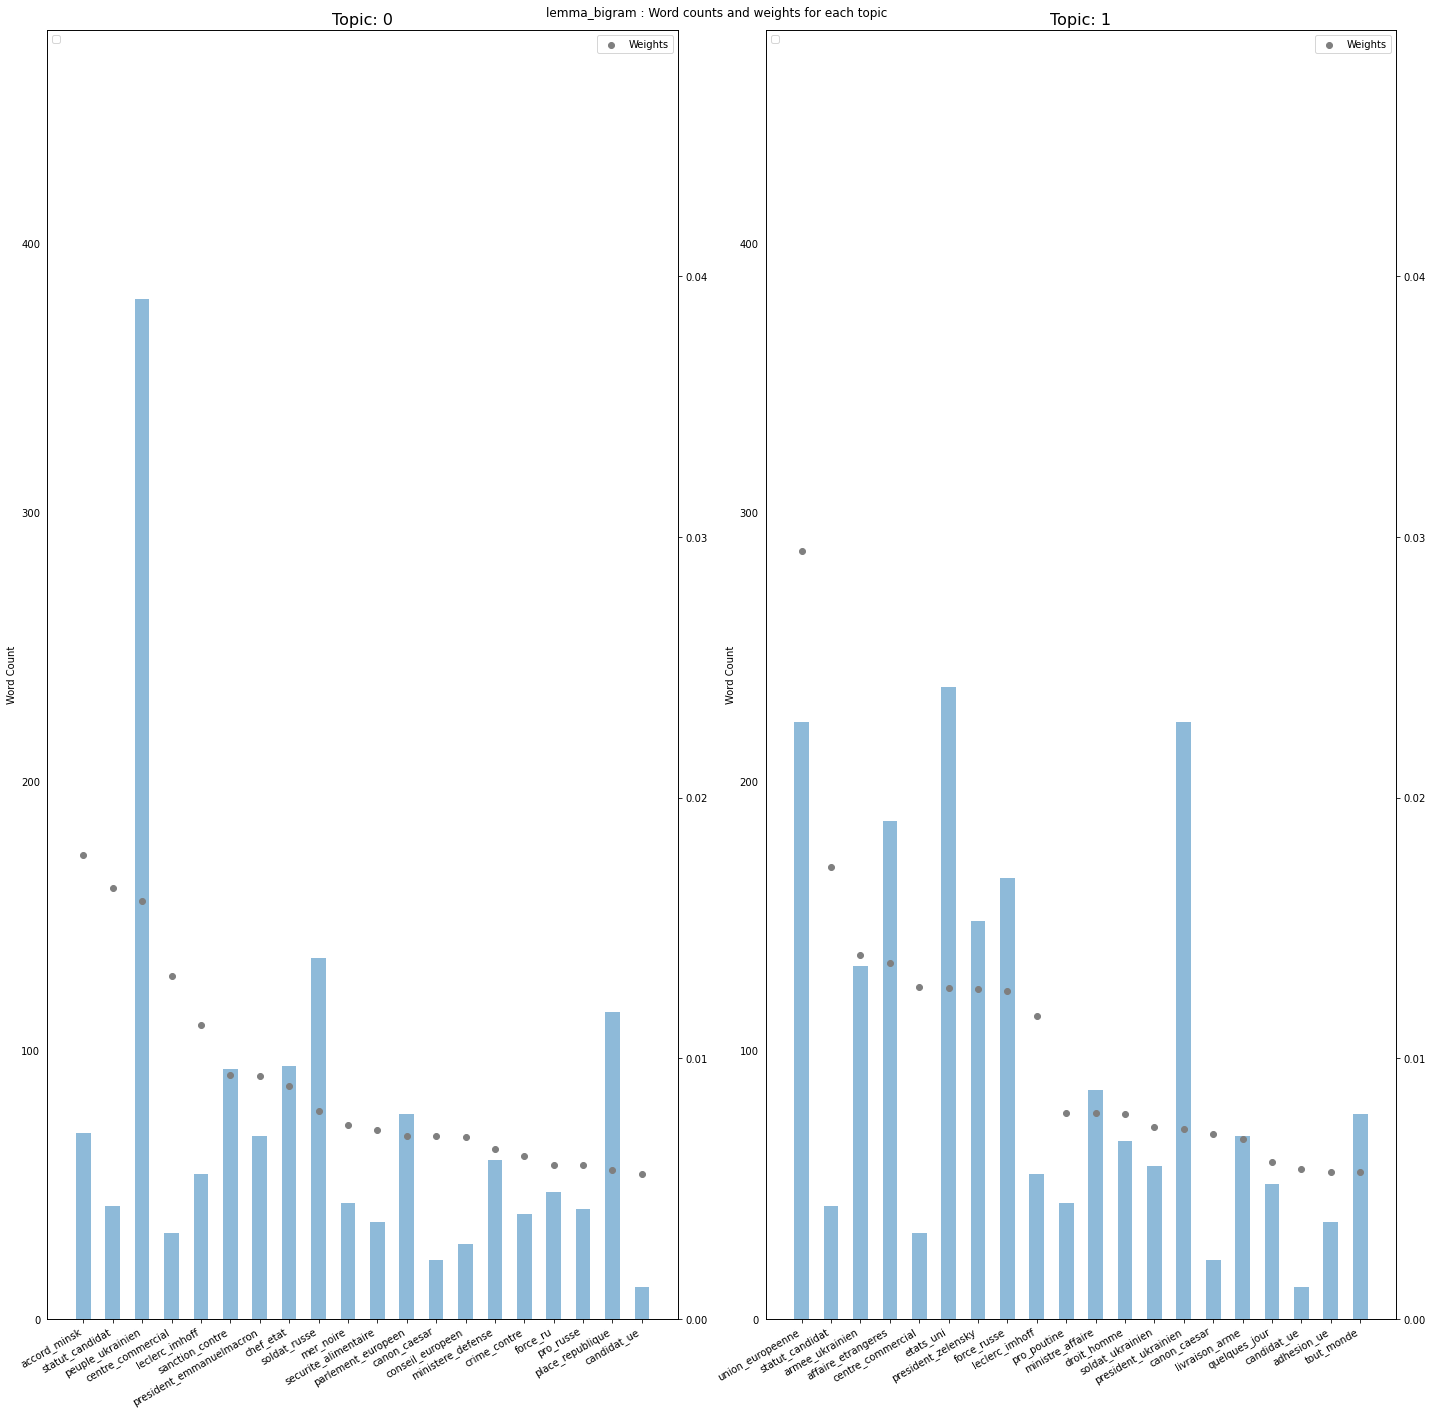

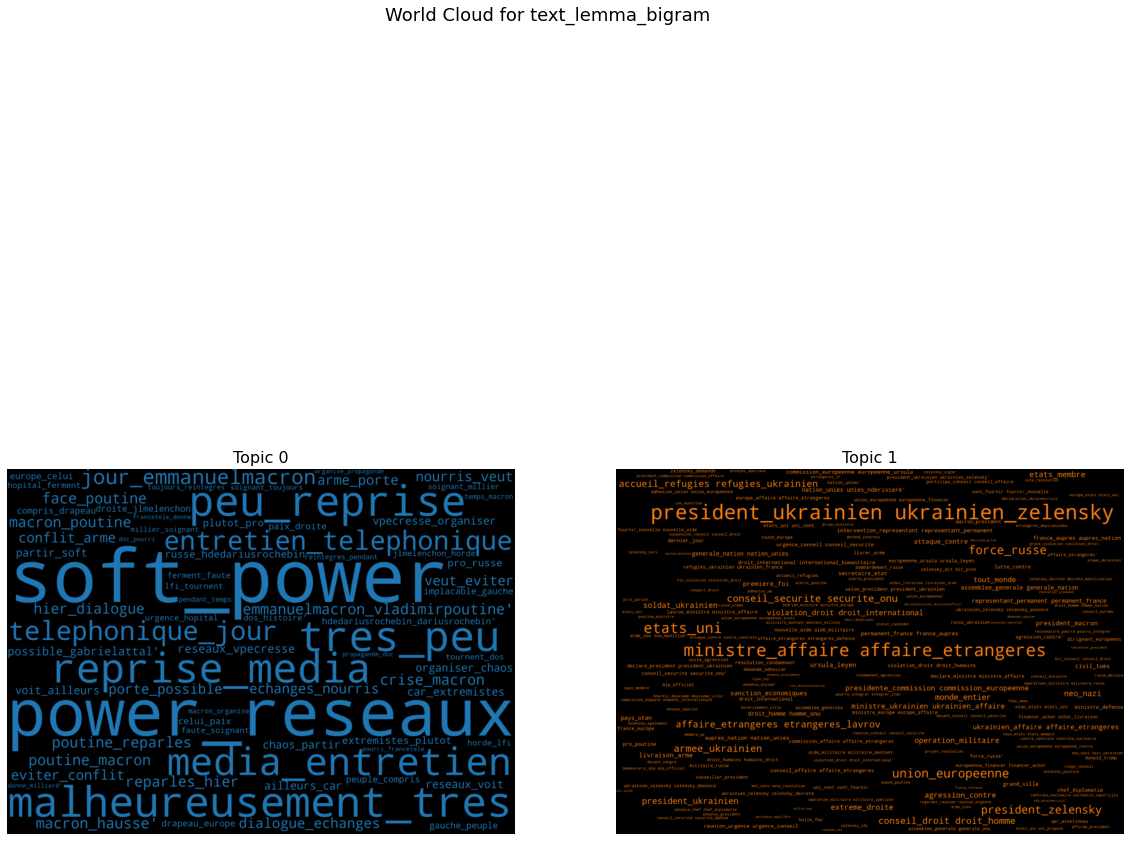

In [21]:
run_all(df_prepro.copy(deep=True), "text_lemma_bigram", "lemma_bigram", False, 2)

In [22]:
df_lemma_bigram_2topics = pd.read_csv(path + "output/min_retweet_3/dominant_topics_lemma_bigram_2topics.csv", sep=";")
filter_columns = ["text", "username", "dominant_topic",
                 "topic_perc_contrib", "keywords"]

df_lemma_bigram_2topics = df_lemma_bigram_2topics[filter_columns]
for i in df_lemma_bigram_2topics["dominant_topic"].unique():
    display(df_lemma_bigram_2topics[
        df_lemma_bigram_2topics["dominant_topic"]==i
    ].sort_values(by=["dominant_topic",
                      "topic_perc_contrib"], ascending=[True, False]).head(20))

text  \
2486   vive émotion place de la république. soutien au peuple ukrainien. nous exigeons le retrait des troupes russes et nous appelons la communauté internationale à oeuvrer pour la paix. #ukraine https://t.co/upljlf1ewq                                                                                                             
1746   l'agression militaire de poutine contre l'#ukraine est d'une extrême gravité &amp; menace toute la sécurité internationale.\r\n\r\nje pense d'abord aux populations civiles.\r\n\r\ntout doit être mis en oeuvre par la 🇨🇵, l'ue et l'onu pour obtenir un cessez le feu &amp; le retrait des troupes russes.                     
8932   pour la liberté des peuples à rester maîtres de leur destin, pour la solidarité avec le peuple ukrainien face à l’invasion russe, pour un sursaut démocratique en russie (place de la république à paris) #ukraine https://t.co/pwtvj5smaz                                                                                       
14489  la sale guerre de #poutine en #ukraine continue, des femmes, des hommes, des enfants meurent toujours sous les bombes russes ! solidarité et soutien à la résistance ukrainienne ! rv samedi 2 avril, 15h, place de la république à #paris pour dire #stopputinnow ! #standwithukraine https://t.co/lx14ffwlwd                   
13850  l’appel de @particivil (💙💛🙏) à manifester le dimanche 27 mars à 17h30, place de la #république à #paris , en soutien au peuple #ukrainien 🇺🇦✊#standwithukraine #ukraine #ukrainians https://t.co/cgqnkqwsga                                                                                                                      
4168   🇺🇦 rassemblés à #lille en soutien au peuple ukrainien, à nos compatriotes en #ukraine et tous les réfugiés. il n’y a pas d’autre solution que la diplomatie au conflit. vite, le cessez-le-feu, le retrait des troupes russes qui n’ont rien à faire en ukraine. construisons la paix ! https://t.co/e7jiabo5it                  
4207   au mans, à nantes, à laval, à st nazaire, à angers... les https://t.co/daj6qvklp3 participent aux rassemblements contre la guerre en #ukraine, en solidarité avec le peuple ukrainien, pour un cessez-le-feu immédiat et le retrait des troupes russes. #paix https://t.co/6kiq2udbxd                                            
4218   au rassemblement avec les https://t.co/p1oiaube1x de nantes contre la guerre en #ukraine, en solidarité avec le peuple ukrainien, pour un cessez-le-feu immédiat et le retrait des troupes russes. #paix https://t.co/6kuhqkqbca                                                                                                 
2429   🟢en direct depuis la place de la république (paris).\r\n👉solidarité avec le peuple ukrainien\r\n👉sanctions fermes envers les oligarques russes \r\n#ukraine #war  https://t.co/lqphoiymc7                                                                                                                                        
3874   soutien au peuple ukrainien\r\nla @_licra_ appelle à participer aux rassemblements organisés en soutien au peuple ukrainien et contre l’agression militaire russe. \r\nla défense de la liberté concerne chacune et chacun d’entre nous. #ukraine 🇺🇦 https://t.co/jrbko8rqd9                                                     
1631   #ukraine : l'unicef intensifie ses efforts afin de venir en aide aux milliers d'enfants qui souffrent quotidiennement des conséquences du conflit armé. \r\nplus de 3,4 millions de personnes, dont 60% de femmes et d'enfants, ont besoin d'une aide humanitaire. https://t.co/3gjv1jwsoj https://t.co/qsnr8qkbjq               
2463   gravité &amp; émotion au rassemblement place de la république en soutien aux ukrainiens &amp; en défense de la paix.\r\n\r\nnous exigeons le retrait des troupes russes et la protection des populations.\r\n\r\ntout doit être mis en oeuvre pour œuvrer à un cessez le feu !\r\n\r\n#ukraine https://t.co/sqktmgypww           
6878   a l’assemblée nationale, en présence 

text  \
3654   vladimir poutine et son ministre des affaires étrangères sergueï lavrov sont désormais visés directement par des sanctions de l'union européenne, du royaume-uni et des etats-unis. #ukraine https://t.co/cdw5n5oprh                                                                                                                
17447  #cae | aujourd'hui, @jy_ledrian participe au conseil affaires étrangères à #bruxelles. #pfue2022 \r\n\r\n📌agression russe contre l'#ukraine \r\n📌 rencontre avec le ministre des affaires étrangères ukrainien et la ministre canadienne des affaires étrangères \r\n📌balkans occidentaux ⤵️ https://t.co/o9ttpesqjm                
18358  🔴🇷🇺 "si l'#ukraine est prête à lancer des opérations de déminages, nous sommes prêts également", a déclaré le ministre russe des affaires étrangères sergueï #lavrov. \r\n\r\nil pointe du doigt la décision du président ukrainien volodymyr #zelensky de "s'opposer à [ces] efforts" ⤵ https://t.co/3qdfzhb1wk                    
4072   #ukraine : puisque le conseil de sécurité est paralysé par le veto de la #russie, @amnesty demande que l’ag des nations unies se réunisse et adopte une résolution condamnant l’attaque russe et exigeant la fin des violations des droits humains et du droit international humanitaire                                            
3652   🇬🇧🇷🇺 le royaume-uni a sanctionné vladimir poutine et son ministre des affaires étrangères, sergueï lavrov. la chancellerie russe a fait savoir que ni le président de la russie ni le chef du ministère des affaires étrangères n'ont de comptes à l'étranger. #ukraine #ukrainerussie                                              
8798   la russie pourrait-elle être exclue du conseil de sécurité de l'onu?\r\n\r\ndepuis l'invasion de l'#ukraine, les sanctions économiques se multiplient contre la russie. londres souhaite lui retirer son siège au conseil de sécurité de l'#onu. est-ce possible? \r\n\r\nhttps://t.co/g0ofywa7yq                                   
8518   #ukraine | @jy_ledrian est en déplacement à bruxelles.\r\n\r\n→ réunion extraordinaire des ministres des affaires étrangères de l'#otan\r\n\r\n→ session du conseil des ministres des affaires étrangères de l'union européenne 🇪🇺\r\n\r\ndéclaration ➡ https://t.co/ekn2wh7gdu \r\n\r\n@nato https://t.co/6tbx4wdr5d               
5613   🇺🇦 guerre en #ukraine\r\n\r\nla présidente de la commission européenne @vonderleyen propose l'adhésion de l'ukraine à l'union européenne 🇪🇺\r\n\r\nle président ukrainien volodymyr zelensky a réagi en souhaitant une intégration de son pays "sans délai" dans l'ue 👉 https://t.co/byhix018kz https://t.co/xodguzx3zj             
1450   ukraine : ça sent le gaz - #lejournal\r\n\r\n➡ https://t.co/rydv5wwrjo\r\n\r\n"l’image du jour, c’est le ministre des affaires étrangères français qui annule une entrevue. une information primordiale puisqu’on apprend qu’il y aurait un ministre des affaires étrangères en france…" #ukraine https://t.co/nhpzqcaiqr           
4330   l’europe et les états-unis s’attaquent à la fortune de poutine et de lavrov.\r\n\r\nles actifs que le président russe et son ministre des affaires étrangères détiennent en europe et aux états-unis sont gelés depuis vendredi. \r\n\r\nhttps://t.co/rbqqn6i7kq\r\n\r\n#ukraine #poutine #russie                                   
10406  l'invasion de l'#ukraine par la #russie a incité des combattants étrangers à se porter volontaires pour rejoindre les soldats ukrainiens.\r\n\r\nils seraient près de 20 000 combattants étrangers à avoir rejoint les rangs de l’armée ukrainienne, selon le ministre des affaires étrangères https://t.co/zwrnpeodyd              
5907   🔴 #ukraine : l'assemblée générale des nations unies se réunit en ce moment même.\r\n\r\nnous demandons qu'elle prenne une résolution dénonçant l'attaque illégale de la russie et appelant à la fin de toutes les violations du droit international humanitaire et des droits humains.                                              
16553  #

## Modèles retenus:
###  Texte lemmatisé avec  3 topics (unigram)
- **Topic 0 (Ukraine) Front :** Ici, c'est l'Ukraine comme théâtre de la guerre qui se profile, avec les actualités militaires et faits des combats sur le terrain. Dans un second temps, les dimensions humaines et sociales directes de ces affrontements apparaissent dans le soutien populaire qui s'organise dans différentes régions du monde, tel que des collectes et envois de biens de première nécessité.

- **Topic 1 (France) Actions officilles :** Cette topic évoque clairement le conflit à travers les actions et déclarations des grandes instances politiques internationales, comme l'Union Européenne, ONU ou OTAN ainsi que différentes ONG comme la Ligue des droits de l'homme.

- **Topic 2 (Poutine) Personalités présidentielles :** Cette topic représente les expressions de la guerre en Ukraine par une sorte de prisme présidentiel. Les tweets ne se concentrent ni sur un type de faits ni d'évènements en particulier. On y évoque directement les présidents (surtout Poutine, Macron et Zélensky) moins en temps que chef d'état, mais plutôt de personnalités parfois assez fortes en présence.

### Text lemmatisé,  bigrame, 2 topics

- Topic 0 **(Peuple ukrainien) Soutien populaire :** Le point de mire ici se situe dans la solidarité avec le peuple ukkrainien, dans une émotion palpable. On l'évoque autour des rassemblements populaires dans de nombreuses villes avec les drapeaux ukrainiens. C'est la marque d'une opinion populaire marquée par la brutalité et l'immoralité voire l'illégalité du déroulement des combats. Enfin, ce soutien transparaît également dans l'envoi de denrées pour les réfugiés.

- **Topic 1 (Union Europeene) Sanctions** : La dimension de cette topic tourne autour de l'organisation des sanctions internationnales. Les tweets rendent compte des différentes salves de sanctions quelques soient leur type et leur origine UE, EU... ou bien leur correlation à un événement en particulier dans le déroulement de la guerre comme des attaques de civils.

### Autres modèles testés mais pas retenus

In [ ]:
run_all(df_prepro.copy(deep=True), "text_stem", "stem", True)
run_all(df_prepro.copy(deep=True), "text_stem", "stem", False, 2)
run_all(df_prepro.copy(deep=True), "text_stem", "stem", False, 4)
run_all(df_prepro.copy(deep=True), "text_lemma_bigram", "lemma_bigram", True)
run_all(df_prepro.copy(deep=True), "text_lemma_bigram", "lemma_bigram", False, 3)
run_all(df_prepro.copy(deep=True), "text_lemma_bigram", "lemma_bigram", False, 4)
run_all(df_prepro.copy(deep=True), "text_stem_bigram", "stem_bigram", True)
run_all(df_prepro.copy(deep=True), "text_stem_bigram", "stem_bigram", False, 2)
run_all(df_prepro.copy(deep=True), "text_stem_bigram", "stem_bigram", False, 5)
run_all(df_prepro.copy(deep=True), "text_lemma_trigram", "lemma_trigram", True)
run_all(df_prepro.copy(deep=True), "text_lemma_trigram", "lemma_trigram", False, 3)
run_all(df_prepro.copy(deep=True), "text_stem_trigram", "stem_trigram", True)
run_all(df_prepro.copy(deep=True), "text_stem_trigram", "stem_trigram", False, 3)
run_all(df_prepro.copy(deep=True), "text_stem_trigram", "stem_trigram", False, 4)